In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd
from sympy import Symbol
from sympy.solvers import solve
import sympy as sp

In [2]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    container['qdp_class']=q
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res


# Set experiment(s) to analyze


In [3]:
exp_ids=['2018_06_27_08_47_15_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_09_09_10_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_09_24_40_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_09_37_39_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_09_54_39_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_10_26_33_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_10_43_31_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_10_56_49_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_11_10_52_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_11_24_27_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_11_43_52_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_12_00_12_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_12_12_41_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_12_25_51_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_12_44_41_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_12_56_08_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_13_07_43_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_13_19_27_Closed-loop Ramsey, Omega Box temperature control',
         '2018_06_27_13_30_49_Closed-loop Ramsey, Omega Box temperature control'
         
         
]

In [4]:
assorted={}
assorted['qdp_class']=[]
assorted['exp_ids']=[]
assorted['timestamps']=[]
assorted['retentions']=[[],[],[],[],[]]
assorted['errors']=[[],[],[],[],[]]
for exp_id in exp_ids:
    container=process_container(exp_id)
    assorted['qdp_class'].append(container['qdp_class'])
    assorted['exp_ids'].append(container['exp_id'])
    assorted['timestamps'].append(container['timestamps'])
    for roi in [0,1,2,3,4]:
        assorted['retentions'][roi].append(container['retentions'][str(roi)])
        assorted['errors'][roi].append(container['errors'][str(roi)])


Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_27/2018_06_27_08_47_15_Closed-loop Ramsey, Omega Box temperature control/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_27/2018_06_27_09_09_10_Closed-loop Ramsey, Omega Box temperature control/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_27/2018_06_27_09_24_40_Closed-loop Ramsey, Omega Box temperature control/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_27/2018_06_27_09_37_39_Closed-loop Ramsey, Omega Box temperature control/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_27/2018_06_27_09_54_39_Closed-loop Ramsey, Omega Box temperature control/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_27/2018_06_27_10_26_33_Closed-loop Ramsey, 

# Experiment-wise analysis

2018_06_27_08_47_15_Closed-loop Ramsey, Omega Box temperature control
0


<IPython.core.display.Javascript object>


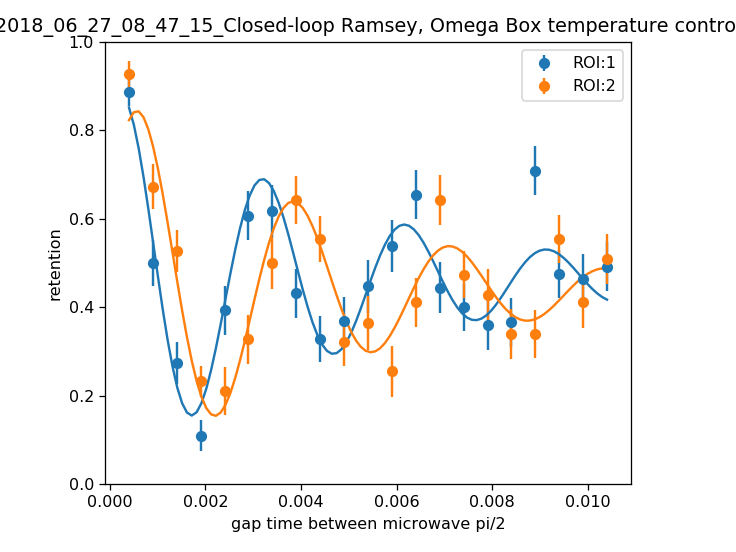

[0.017, 0.41657741002609727, 310, 1.5707963267948966, 0.46949853934099128]
tau 1  is  0.00491315995523  with 1 std of   0.0012120562768
amplitude 1  is  0.437860162695  with 1 std of   0.0698726588126
frequency 1  is  337.303859677  with 1 std of   8.76672884755
phase 1  is  0.991251333349  with 1 std of   0.188096254848
offset 1  is  0.462503167942  with 1 std of   0.0159595267374
[0.017, 0.46817612212349041, 310, 1.5707963267948966, 0.45909660514923684]
tau 2  is  0.00464370159502  with 1 std of   0.00112002763113
amplitude 2  is  0.460250951709  with 1 std of   0.0716102247287
frequency 2  is  306.160603777  with 1 std of   9.70802070184
phase 2  is  0.373607294614  with 1 std of   0.203477439201
offset 2  is  0.439001072828  with 1 std of   0.0168877611121
2018_06_27_09_09_10_Closed-loop Ramsey, Omega Box temperature control
1


<IPython.core.display.Javascript object>


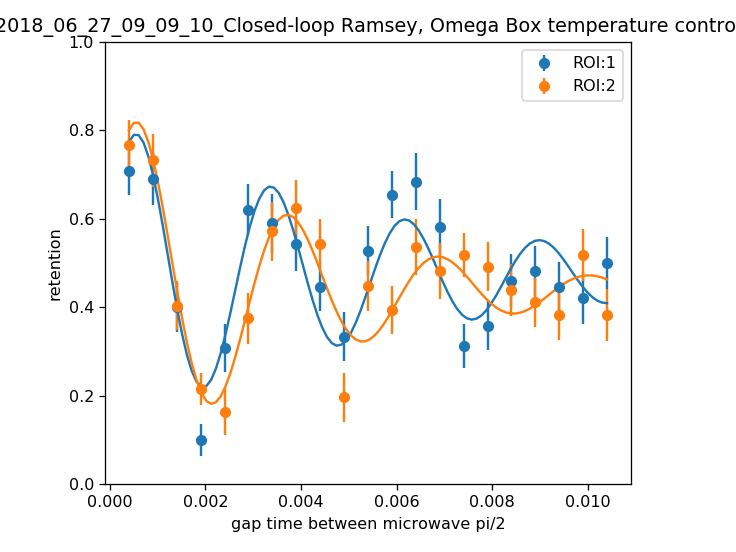

[0.017, 0.22426442627174753, 310, 1.5707963267948966, 0.48406890706158584]
tau 1  is  0.00606681106485  with 1 std of   0.00199720530633
amplitude 1  is  0.350532867792  with 1 std of   0.0683079638716
frequency 1  is  355.709987882  with 1 std of   9.81281058379
phase 1  is  0.273122859348  with 1 std of   0.236778781708
offset 1  is  0.472130662127  with 1 std of   0.0173478032055
[0.017, 0.31110912824680004, 310, 1.5707963267948966, 0.45674801461034287]
tau 2  is  0.00394785078552  with 1 std of   0.000952814403492
amplitude 2  is  0.443011337235  with 1 std of   0.0716689028734
frequency 2  is  316.972063933  with 1 std of   11.391367435
phase 2  is  0.340057426197  with 1 std of   0.214698390249
offset 2  is  0.437235051316  with 1 std of   0.0156932127655
2018_06_27_09_24_40_Closed-loop Ramsey, Omega Box temperature control
2


<IPython.core.display.Javascript object>


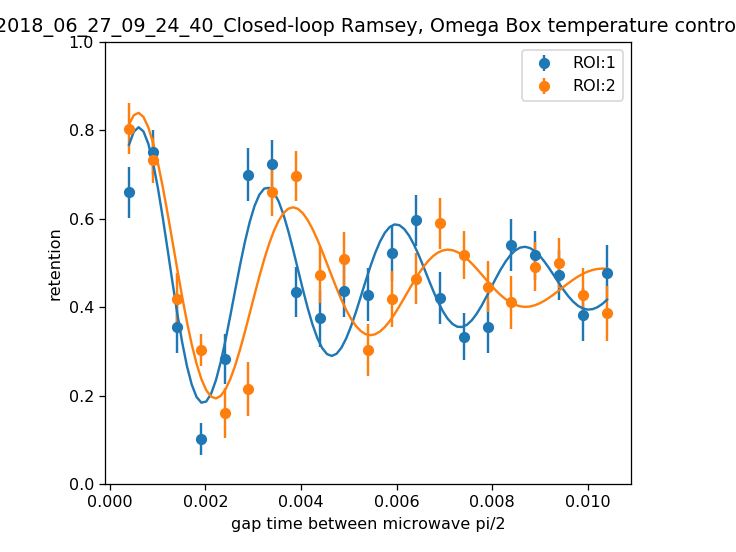

[0.017, 0.28019967392623357, 310, 1.5707963267948966, 0.46980032607376643]
tau 1  is  0.00545543574252  with 1 std of   0.00150530353651
amplitude 1  is  0.392341491734  with 1 std of   0.0672534043245
frequency 1  is  371.74183761  with 1 std of   8.71348433337
phase 1  is  0.0842131167847  with 1 std of   0.198255196024
offset 1  is  0.456784004807  with 1 std of   0.0160068076285
[0.017, 0.33078692402000676, 310, 1.5707963267948966, 0.47278450455142185]
tau 2  is  0.00403479741549  with 1 std of   0.00108311809782
amplitude 2  is  0.451658550338  with 1 std of   0.0813637221902
frequency 2  is  308.393687045  with 1 std of   12.3012556804
phase 2  is  0.304735650668  with 1 std of   0.234969325303
offset 2  is  0.452563373046  with 1 std of   0.0178174217764
2018_06_27_09_37_39_Closed-loop Ramsey, Omega Box temperature control
3


<IPython.core.display.Javascript object>


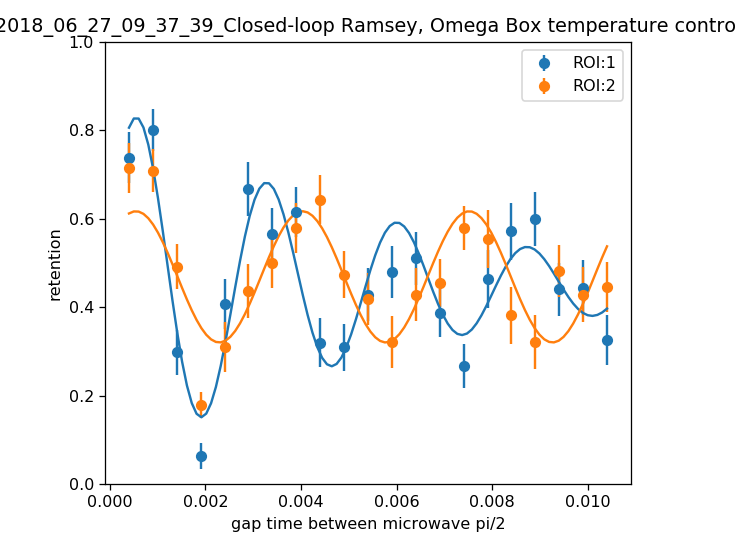

[0.017, 0.33800742789832566, 310, 1.5707963267948966, 0.46199257210167438]
tau 1  is  0.00556472649112  with 1 std of   0.0015711154355
amplitude 1  is  0.421388082373  with 1 std of   0.0727823258923
frequency 1  is  367.000132629  with 1 std of   9.03245836734
phase 1  is  0.222890513084  with 1 std of   0.20855138113
offset 1  is  0.448790746327  with 1 std of   0.0178767173318
[0.017, 0.24524975859562331, 310, 1.5707963267948966, 0.46903595569009099]
tau 2  is  -107300.95168  with 1 std of   491373475011.0
amplitude 2  is  0.148447368683  with 1 std of   0.0534386300027
frequency 2  is  286.863182108  with 1 std of   9.68880307749
phase 2  is  0.588011251281  with 1 std of   0.390590244148
offset 2  is  0.468555642126  with 1 std of   0.019189043925
2018_06_27_09_54_39_Closed-loop Ramsey, Omega Box temperature control
4


<IPython.core.display.Javascript object>


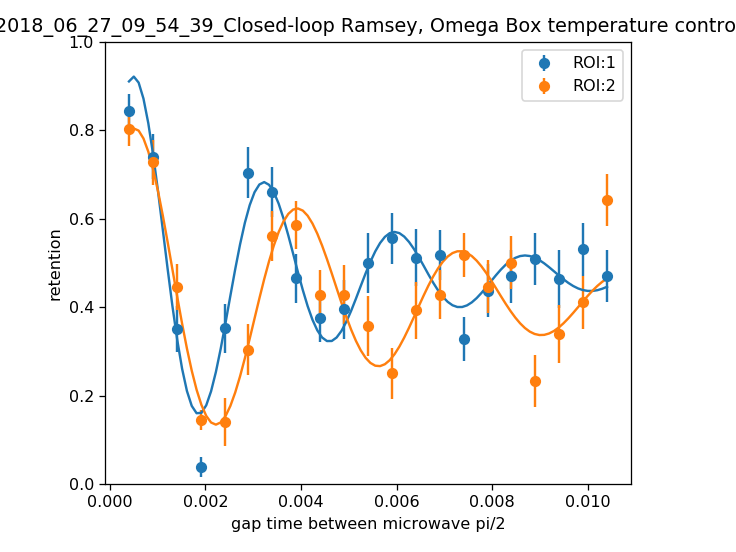

[0.017, 0.35709141841449243, 310, 1.5707963267948966, 0.48665858158550757]
tau 1  is  0.00364015293116  with 1 std of   0.000635728923842
amplitude 1  is  0.52188235362  with 1 std of   0.0615554337181
frequency 1  is  366.278543684  with 1 std of   8.80767579098
phase 1  is  0.314013323967  with 1 std of   0.155979220922
offset 1  is  0.469279947418  with 1 std of   0.0129807118205
[0.017, 0.37074952458022198, 310, 1.5707963267948966, 0.43282190399120662]
tau 2  is  0.00540237386918  with 1 std of   0.00139754096071
amplitude 2  is  0.428291953887  with 1 std of   0.0668149820017
frequency 2  is  293.867770194  with 1 std of   8.73139014294
phase 2  is  0.519884273515  with 1 std of   0.202875288505
offset 2  is  0.416964460059  with 1 std of   0.0169274948733
2018_06_27_10_26_33_Closed-loop Ramsey, Omega Box temperature control
5


<IPython.core.display.Javascript object>


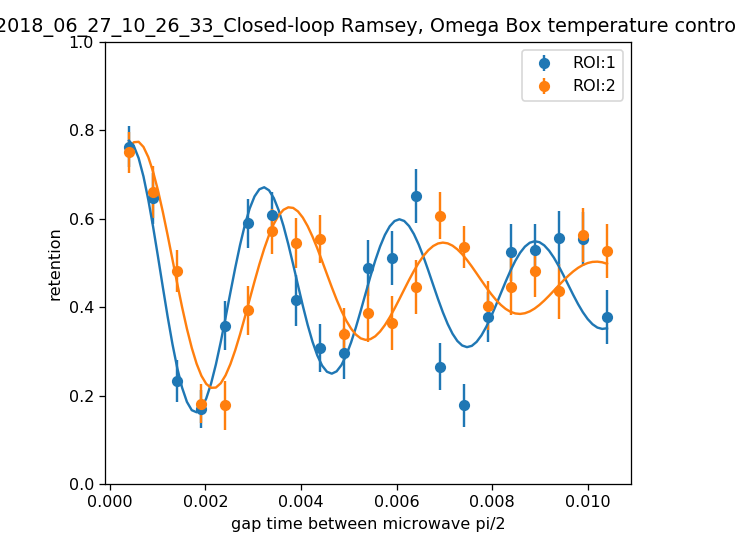

[0.017, 0.31527122001024921, 310, 1.5707963267948966, 0.44744064439653042]
tau 1  is  0.00753108975223  with 1 std of   0.00255734261501
amplitude 1  is  0.354290976948  with 1 std of   0.0643471419765
frequency 1  is  352.177352438  with 1 std of   8.29131722198
phase 1  is  0.674282172089  with 1 std of   0.220566776809
offset 1  is  0.44061543711  with 1 std of   0.0175893616926
[0.017, 0.28075790124662303, 310, 1.5707963267948966, 0.46924209875337697]
tau 2  is  0.00516267228037  with 1 std of   0.00113507077131
amplitude 2  is  0.360864086874  with 1 std of   0.049775524806
frequency 2  is  312.003889307  with 1 std of   8.01116759163
phase 2  is  0.377217098292  with 1 std of   0.178246180433
offset 2  is  0.452933510331  with 1 std of   0.0122248275137
2018_06_27_10_43_31_Closed-loop Ramsey, Omega Box temperature control
6


<IPython.core.display.Javascript object>


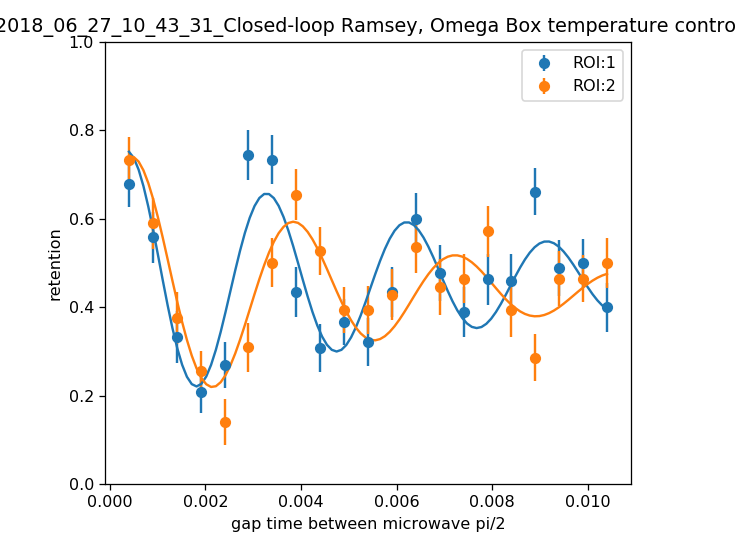

[0.017, 0.27629745785191984, 310, 1.5707963267948966, 0.46788858865970806]
tau 1  is  0.00733625631077  with 1 std of   0.0031183296355
amplitude 1  is  0.307777257372  with 1 std of   0.0703585812262
frequency 1  is  341.020971574  with 1 std of   10.2525954456
phase 1  is  0.769195533555  with 1 std of   0.272880442
offset 1  is  0.460600766202  with 1 std of   0.0188898038102
[0.017, 0.28349906150658027, 310, 1.5707963267948966, 0.44864379563627682]
tau 2  is  0.00509462890326  with 1 std of   0.00157646586852
amplitude 2  is  0.333760989891  with 1 std of   0.0637337048475
frequency 2  is  295.55814992  with 1 std of   11.373822797
phase 2  is  0.622592648797  with 1 std of   0.254561075265
offset 2  is  0.437009260772  with 1 std of   0.0159677771939
2018_06_27_10_56_49_Closed-loop Ramsey, Omega Box temperature control
7


<IPython.core.display.Javascript object>


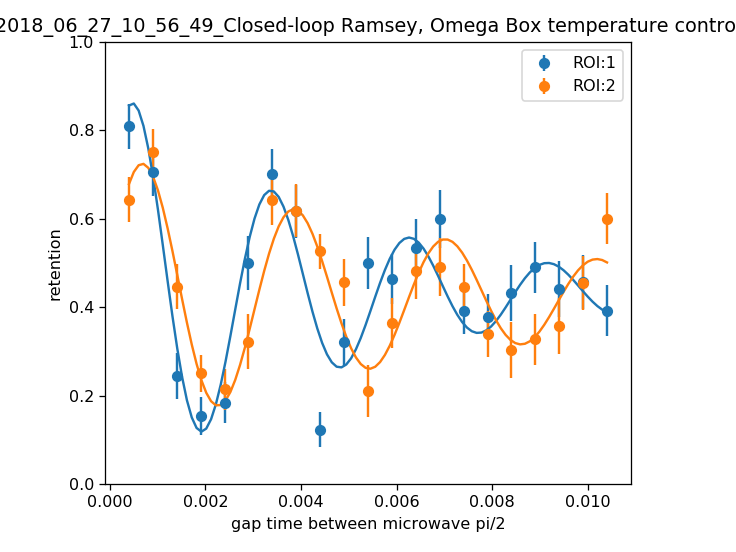

[0.017, 0.35997061265891195, 310, 1.5707963267948966, 0.44955319686489759]
tau 1  is  0.0046834188494  with 1 std of   0.00123146503909
amplitude 1  is  0.476273396672  with 1 std of   0.0796863294039
frequency 1  is  345.600147836  with 1 std of   10.2236036008
phase 1  is  0.446994183485  with 1 std of   0.216052507208
offset 1  is  0.432998152245  with 1 std of   0.0188080784785
[0.017, 0.30979666848865711, 310, 1.5707963267948966, 0.44020333151134289]
tau 2  is  0.00760183844203  with 1 std of   0.00218550659688
amplitude 2  is  0.33109819798  with 1 std of   0.0515123527539
frequency 2  is  315.583799084  with 1 std of   6.88888611599
phase 2  is  0.160625789399  with 1 std of   0.182669390158
offset 2  is  0.422341711708  with 1 std of   0.0138004684651
2018_06_27_11_10_52_Closed-loop Ramsey, Omega Box temperature control
8


<IPython.core.display.Javascript object>


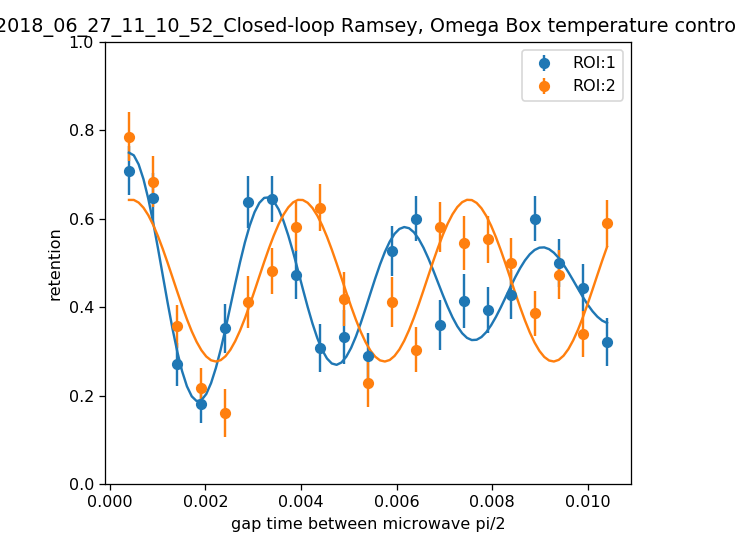

[0.017, 0.2591862086447535, 310, 1.5707963267948966, 0.44914712468857987]
tau 1  is  0.00731833539264  with 1 std of   0.00196183054279
amplitude 1  is  0.327320895223  with 1 std of   0.0472809643196
frequency 1  is  347.1989915  with 1 std of   6.65987686653
phase 1  is  0.61585874878  with 1 std of   0.176316063601
offset 1  is  0.440667604816  with 1 std of   0.0128453468898
[0.017, 0.32689326129175766, 310, 1.5707963267948966, 0.45882102442252803]
tau 2  is  -335784.773824  with 1 std of   1.92646301392e+12
amplitude 2  is  0.1831258752  with 1 std of   0.0409188124413
frequency 2  is  283.216628979  with 1 std of   9.18022501794
phase 2  is  0.770786717278  with 1 std of   0.375087596223
offset 2  is  0.460182625398  with 1 std of   0.0229919277034
2018_06_27_11_24_27_Closed-loop Ramsey, Omega Box temperature control
9


<IPython.core.display.Javascript object>


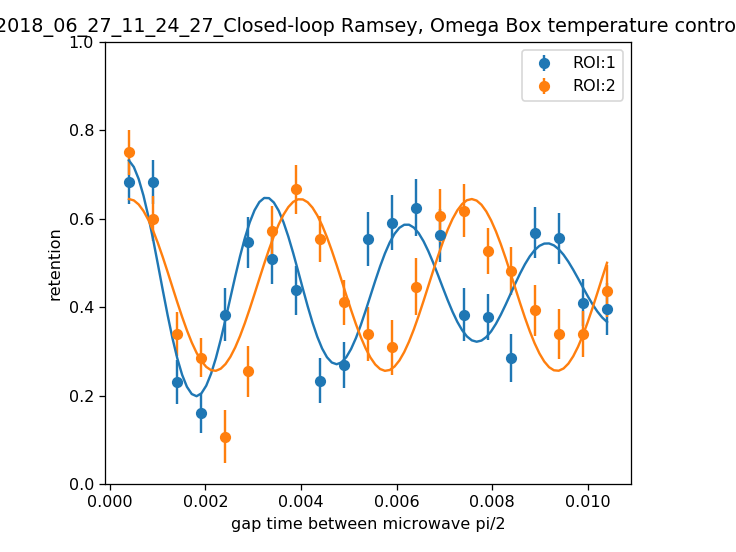

[0.017, 0.23435526078159435, 310, 1.5707963267948966, 0.44985526553419514]
tau 1  is  0.00836107961817  with 1 std of   0.00374826396851
amplitude 1  is  0.30384786959  with 1 std of   0.0682708273079
frequency 1  is  340.708586631  with 1 std of   9.42859918845
phase 1  is  0.7887752439  with 1 std of   0.264093983195
offset 1  is  0.442951652563  with 1 std of   0.0189029039707
[0.017, 0.30350443207586075, 310, 1.5707963267948966, 0.44649556792413925]
tau 2  is  -154453.309656  with 1 std of   578135024022.0
amplitude 2  is  0.194377251234  with 1 std of   0.0478491782437
frequency 2  is  279.128473298  with 1 std of   7.23379174188
phase 2  is  0.870615499328  with 1 std of   0.286153805739
offset 2  is  0.450224200614  with 1 std of   0.019596753953
2018_06_27_11_43_52_Closed-loop Ramsey, Omega Box temperature control
10


<IPython.core.display.Javascript object>


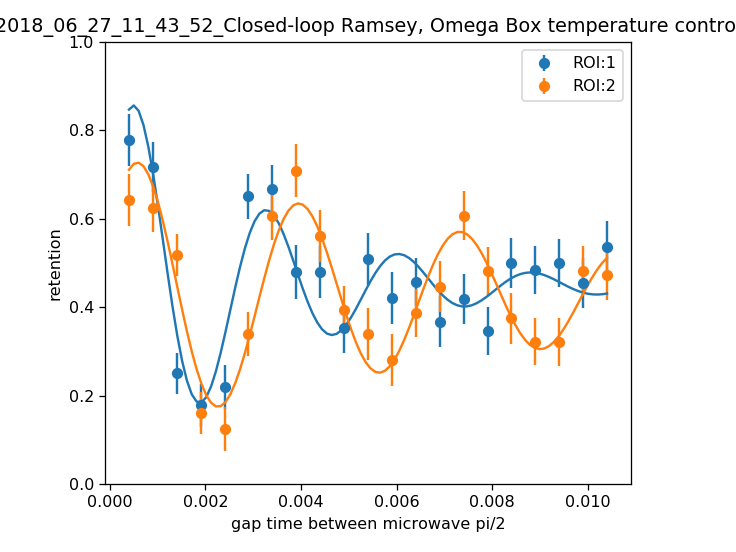

[0.017, 0.3127638016905771, 310, 1.5707963267948966, 0.46501397608720069]
tau 1  is  0.00319595616803  with 1 std of   0.000841218824883
amplitude 1  is  0.480768312219  with 1 std of   0.0869401456346
frequency 1  is  361.141884434  with 1 std of   15.3279555169
phase 1  is  0.314536181993  with 1 std of   0.246689576071
offset 1  is  0.448228569828  with 1 std of   0.0172364001606
[0.017, 0.27120506894942986, 310, 1.5707963267948966, 0.43788584014147924]
tau 2  is  0.00920623187087  with 1 std of   0.002657623958
amplitude 2  is  0.321500268458  with 1 std of   0.0432646899801
frequency 2  is  296.655735636  with 1 std of   5.59337956046
phase 2  is  0.438919953048  with 1 std of   0.163020809371
offset 2  is  0.425695999483  with 1 std of   0.0125736833268
2018_06_27_12_00_12_Closed-loop Ramsey, Omega Box temperature control
11


<IPython.core.display.Javascript object>


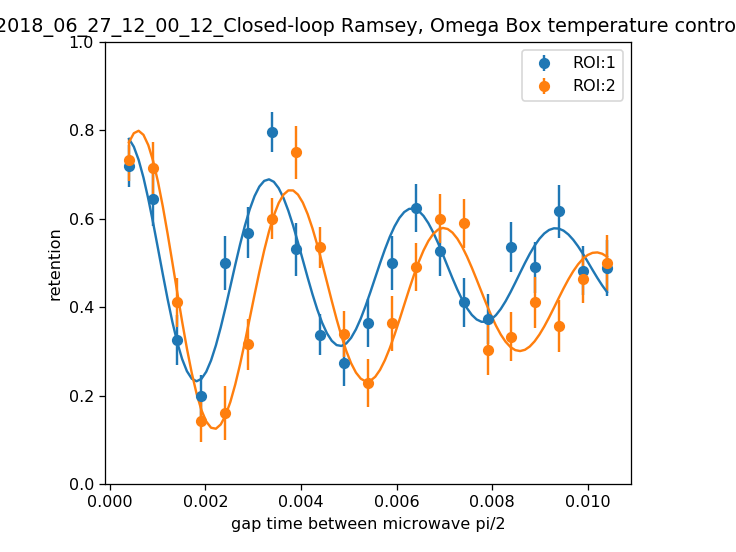

[0.017, 0.30533170282894556, 310, 1.5707963267948966, 0.49096459346735072]
tau 1  is  0.0078425328227  with 1 std of   0.00249473086528
amplitude 1  is  0.315994433124  with 1 std of   0.0517625104334
frequency 1  is  332.870341555  with 1 std of   6.86758231856
phase 1  is  0.854782666128  with 1 std of   0.189859657562
offset 1  is  0.482635485252  with 1 std of   0.013953823929
[0.017, 0.30512129891829143, 310, 1.5707963267948966, 0.44487870108170857]
tau 2  is  0.00722052807306  with 1 std of   0.00140499861201
amplitude 2  is  0.407339735518  with 1 std of   0.0435210840796
frequency 2  is  313.089621586  with 1 std of   5.05781903192
phase 2  is  0.341966392026  with 1 std of   0.132233982114
offset 2  is  0.424628514458  with 1 std of   0.0118292345556
2018_06_27_12_12_41_Closed-loop Ramsey, Omega Box temperature control
12


<IPython.core.display.Javascript object>


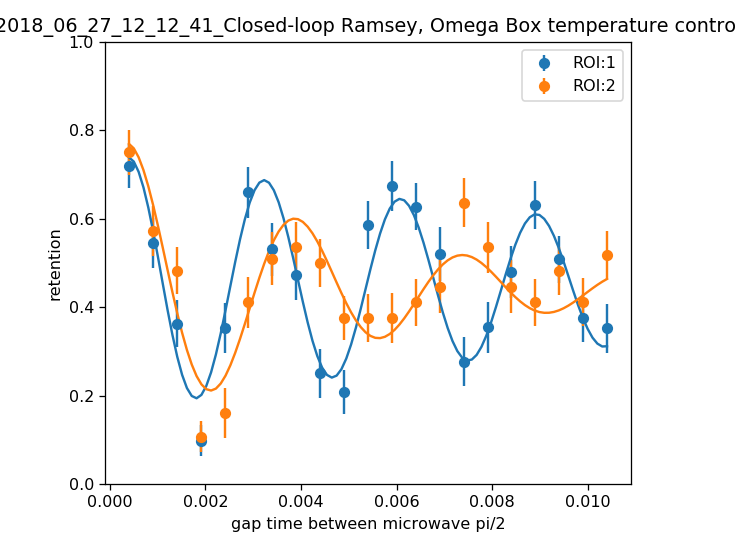

[0.017, 0.26291407126291227, 310, 1.5707963267948966, 0.45638417435112283]
tau 1  is  0.0142800086266  with 1 std of   0.00674824024874
amplitude 1  is  0.294125982259  with 1 std of   0.0490291892387
frequency 1  is  351.39415262  with 1 std of   6.07323034469
phase 1  is  0.697238733654  with 1 std of   0.194281936316
offset 1  is  0.452930405723  with 1 std of   0.0152556995304
[0.017, 0.30007570426289626, 310, 1.5707963267948966, 0.44992429573710374]
tau 2  is  0.00483575070634  with 1 std of   0.00138346119074
amplitude 2  is  0.357174020738  with 1 std of   0.0639357351813
frequency 2  is  284.803529157  with 1 std of   10.8091880229
phase 2  is  0.824614147187  with 1 std of   0.236004018062
offset 2  is  0.440772272991  with 1 std of   0.0155985941183
2018_06_27_12_25_51_Closed-loop Ramsey, Omega Box temperature control
13


<IPython.core.display.Javascript object>


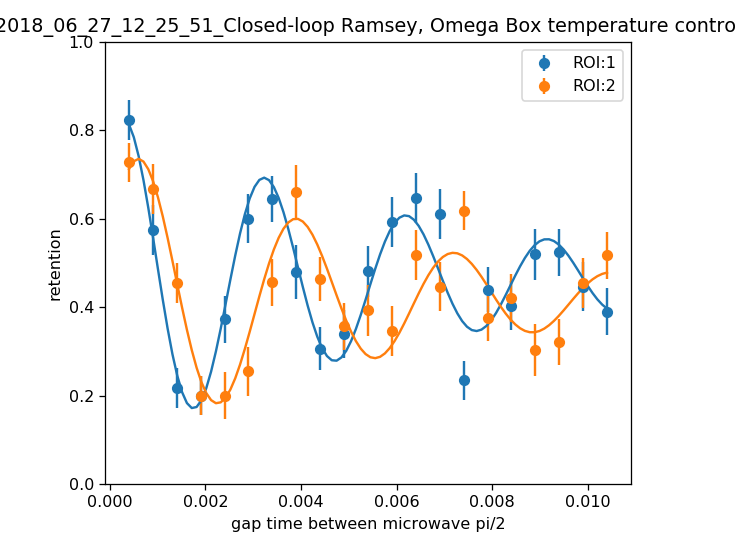

[0.017, 0.35475645266123074, 310, 1.5707963267948966, 0.46877295910347511]
tau 1  is  0.00643211441321  with 1 std of   0.00151872538192
amplitude 1  is  0.382531919694  with 1 std of   0.0522997909716
frequency 1  is  338.033616294  with 1 std of   6.37929233082
phase 1  is  0.930632459086  with 1 std of   0.159232869253
offset 1  is  0.461885141743  with 1 std of   0.0132370680741
[0.017, 0.29132357502204537, 310, 1.5707963267948966, 0.43594915225068193]
tau 2  is  0.00587237451697  with 1 std of   0.00165760807014
amplitude 2  is  0.350349360041  with 1 std of   0.0590516353821
frequency 2  is  303.472284799  with 1 std of   8.82351430195
phase 2  is  0.340136118889  with 1 std of   0.211059447048
offset 2  is  0.420424804125  with 1 std of   0.0150372046628
2018_06_27_12_44_41_Closed-loop Ramsey, Omega Box temperature control
14


<IPython.core.display.Javascript object>


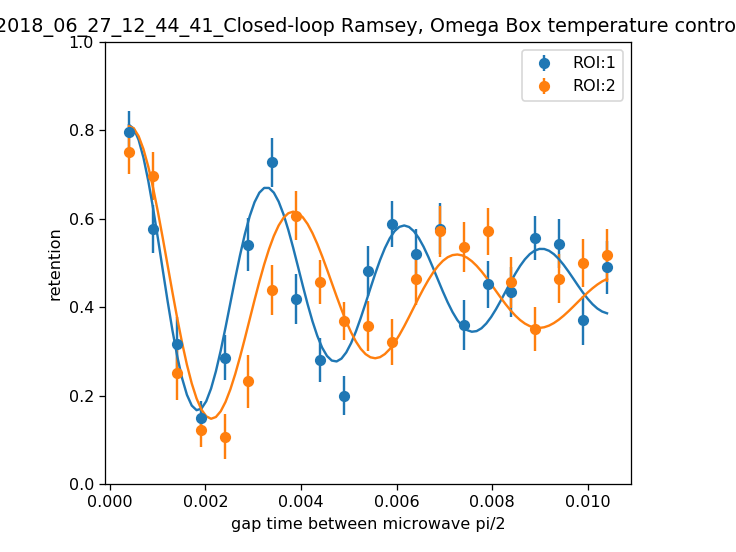

[0.017, 0.3357049933441848, 310, 1.5707963267948966, 0.46021337400275397]
tau 1  is  0.0058263878203  with 1 std of   0.00152225737865
amplitude 1  is  0.389566887154  with 1 std of   0.0606957788359
frequency 1  is  347.553466899  with 1 std of   8.21024346737
phase 1  is  0.61800600557  with 1 std of   0.195438473284
offset 1  is  0.44977991414  with 1 std of   0.0154587466435
[0.017, 0.31478995106814667, 310, 1.5707963267948966, 0.43521004893185333]
tau 2  is  0.00495247236649  with 1 std of   0.00143314520819
amplitude 2  is  0.423902019745  with 1 std of   0.076216263294
frequency 2  is  292.166447468  with 1 std of   10.8873126195
phase 2  is  0.702271466549  with 1 std of   0.240258847049
offset 2  is  0.421849167519  with 1 std of   0.0189151636723
2018_06_27_12_56_08_Closed-loop Ramsey, Omega Box temperature control
15


<IPython.core.display.Javascript object>


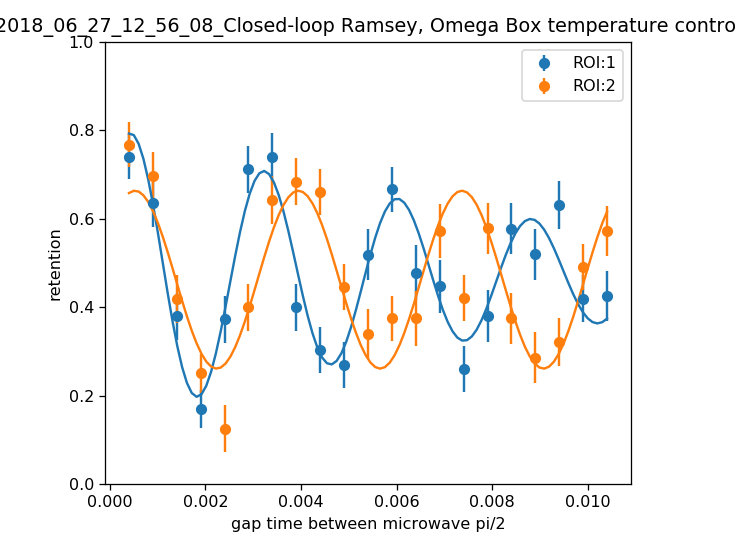

[0.017, 0.26236709234603955, 310, 1.5707963267948966, 0.47837364839470115]
tau 1  is  0.00904655531679  with 1 std of   0.00284418891099
amplitude 1  is  0.337090036602  with 1 std of   0.0509417354102
frequency 1  is  358.191869419  with 1 std of   6.37871682224
phase 1  is  0.556722025061  with 1 std of   0.181692694109
offset 1  is  0.472308567548  with 1 std of   0.0146162285382
[0.017, 0.30133938742961308, 310, 1.5707963267948966, 0.46651775542752982]
tau 2  is  -131311.345254  with 1 std of   473757192566.0
amplitude 2  is  0.20127943709  with 1 std of   0.0504053109675
frequency 2  is  292.52643317  with 1 std of   7.8912509704
phase 2  is  0.603565600602  with 1 std of   0.30894144233
offset 2  is  0.462217420473  with 1 std of   0.0205932904808
2018_06_27_13_07_43_Closed-loop Ramsey, Omega Box temperature control
16


<IPython.core.display.Javascript object>


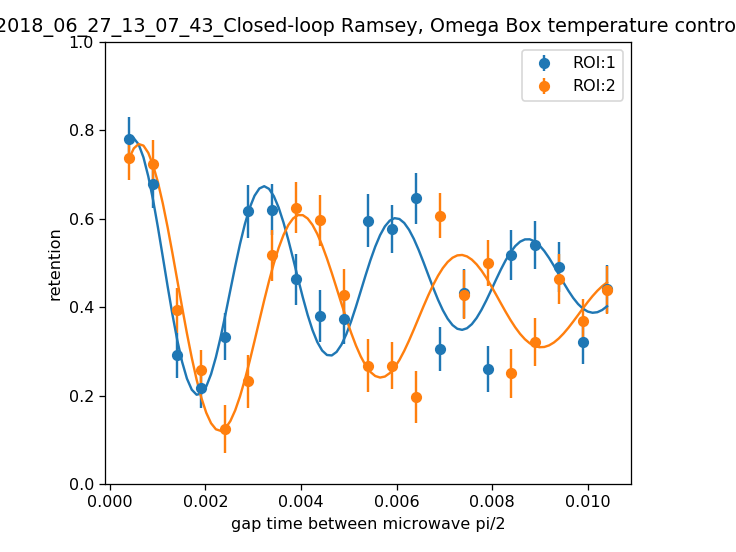

[0.017, 0.30956582062041388, 310, 1.5707963267948966, 0.47043417937958615]
tau 1  is  0.00661784966417  with 1 std of   0.00209630849577
amplitude 1  is  0.345332114768  with 1 std of   0.0618405874719
frequency 1  is  362.76671464  with 1 std of   8.71056395907
phase 1  is  0.438792922831  with 1 std of   0.220127795771
offset 1  is  0.461978656303  with 1 std of   0.0163628190185
[0.017, 0.32026546250684179, 310, 1.5707963267948966, 0.41657664275631606]
tau 2  is  0.00592568219858  with 1 std of   0.00172998663454
amplitude 2  is  0.413212647901  with 1 std of   0.0711622839012
frequency 2  is  297.763532255  with 1 std of   8.69604662331
phase 2  is  0.311634806738  with 1 std of   0.210822220076
offset 2  is  0.399028145058  with 1 std of   0.0179995950977
2018_06_27_13_19_27_Closed-loop Ramsey, Omega Box temperature control
17


<IPython.core.display.Javascript object>


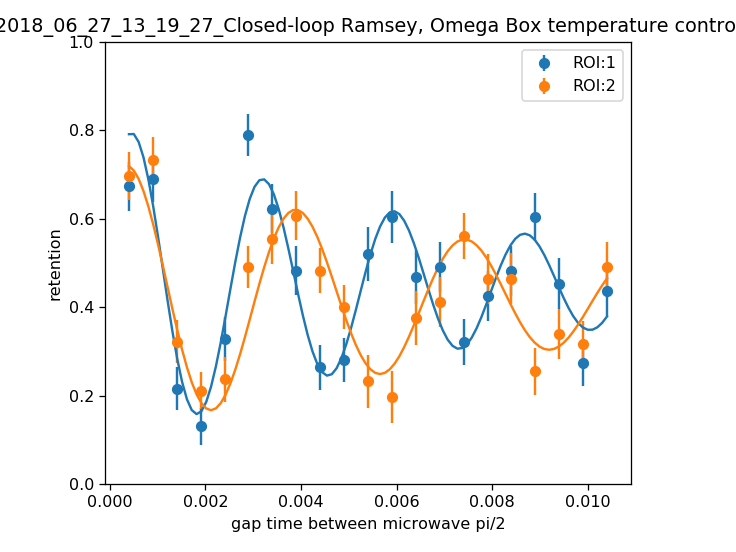

[0.017, 0.33338190175270771, 310, 1.5707963267948966, 0.45507963670883073]
tau 1  is  0.0076801735145  with 1 std of   0.00241217676974
amplitude 1  is  0.36776418983  with 1 std of   0.0604045021962
frequency 1  is  364.932692146  with 1 std of   7.34306807197
phase 1  is  0.477185282049  with 1 std of   0.198469061389
offset 1  is  0.447605645364  with 1 std of   0.0166304803028
[0.017, 0.31140730614414824, 310, 1.5707963267948966, 0.42073555099870885]
tau 2  is  0.00889180496755  with 1 std of   0.00318222922565
amplitude 2  is  0.316858963505  with 1 std of   0.0535653518203
frequency 2  is  282.799247935  with 1 std of   6.8907990612
phase 2  is  0.890110257121  with 1 std of   0.200741377259
offset 2  is  0.416151629113  with 1 std of   0.0153548487813
2018_06_27_13_30_49_Closed-loop Ramsey, Omega Box temperature control
18


<IPython.core.display.Javascript object>


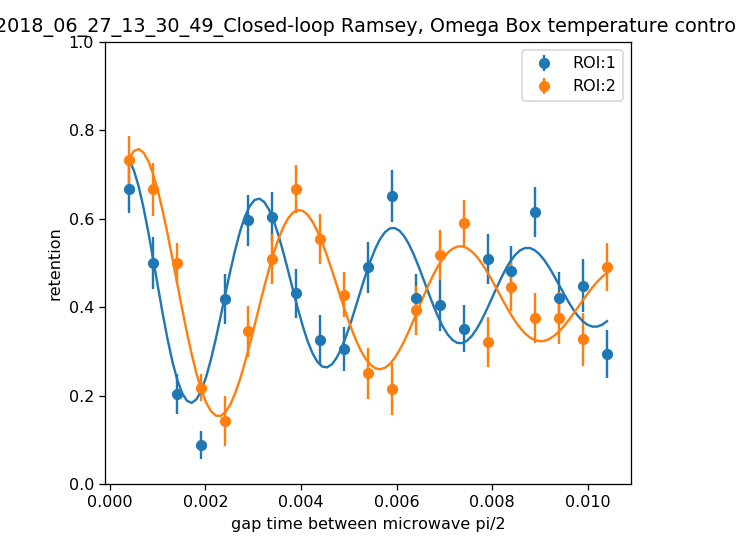

[0.017, 0.22726775749500883, 310, 1.5707963267948966, 0.4393989091716578]
tau 1  is  0.00741050097911  with 1 std of   0.00242228115246
amplitude 1  is  0.318786619397  with 1 std of   0.0565632052882
frequency 1  is  355.248711915  with 1 std of   7.90335115255
phase 1  is  0.861210896935  with 1 std of   0.207975160461
offset 1  is  0.436462062545  with 1 std of   0.0150734343622
[0.017, 0.30056146860658139, 310, 1.5707963267948966, 0.4315813885362757]
tau 2  is  0.00651871856749  with 1 std of   0.00157098489375
amplitude 2  is  0.374628405189  with 1 std of   0.0508049028614
frequency 2  is  296.683829409  with 1 std of   6.59669931069
phase 2  is  0.392303317482  with 1 std of   0.167959760075
offset 2  is  0.416543426373  with 1 std of   0.0134272742047


In [5]:
save_figures=False
data11 = []
for n in range(0,len(assorted['exp_ids'])):    
    print assorted['exp_ids'][n]
    assorted_roi3freqs=[]
    assorted_roi2freqs=[]
    assorted_roi3perr=[]
    assorted_roi2perr=[]
    i = n
    print i
    exp_id=assorted['exp_ids'][i]
    q=assorted['qdp_class'][i]
    q.experiments[0]['variable_list']
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    q.get_thresholds()
    retention = q.apply_thresholds()


    colors=[ '#ff7f0e','#1f77b4','#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    fig, ax = plt.subplots()
    fit_guesses=[0.006, 0.43, 409 ,1.107, 0.47]
    #fit_guesses2=[  0.522, 0.411, 190 ,1.52, 0.5]
    #roi_dependency=[0,0,0,0,0]
    fitted_parameters=[]
    freqarray = []
    for roi in [1,2]:
        error=0
        data = []
        reten = []
        err = []

        for e in range(len(np.squeeze(retention['ivar']))):
            data.append(np.squeeze(retention['ivar'])[e][roi])
            reten.append(np.squeeze(retention['retention'])[e][roi])
            err.append(np.squeeze(retention['error'])[e][roi])
        offsetguess = np.mean(reten)
        Ampguess = np.max(reten)-offsetguess
        fit_guesses = [0.017,Ampguess , 310 ,np.pi/2, offsetguess]   
        print fit_guesses
        ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
        #guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
        #try:
       # decaying_sin(t,tau,amp,freq,phase,offset)
        try:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offset',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

        except:
            fit,pcov = curve_fit(decaying_sin,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
            perr = np.sqrt(np.diag(pcov))
            print 'tau',roi," is ", fit[0]," with 1 std of  ", perr[0]
            print 'amplitude',roi," is ", fit[1]," with 1 std of  ", perr[1]
            print 'frequency',roi," is ", fit[2]," with 1 std of  ", perr[2]
            print 'phase', roi," is ", fit[3]," with 1 std of  ", perr[3]
            print 'offsett',roi," is ", fit[4]," with 1 std of  ", perr[4]
            freqarray.append(fit[2])
            freqarray.append(perr[2])

           #fit2,pcov2 = curve_fit(gaussian,data,reten,fit_guesses2) #gaussian(x,amp,x0,sigma,offset):
       # except RuntimeError:
       #     error=1
    #     if error is not 1:
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit[0],fit[1],fit[2])
    #         print "amplitude: {} , x0: {}, sigma:{} ".format(fit2[0],fit2[1],fit2[2])

        xarray=np.linspace(np.min(data),np.max(data),100)
        yfit=decaying_sin(xarray, fit[0], fit[1], fit[2], fit[3],fit[4])
       # yfit2=decaying_sin(xarray, 0.522, 0.411, 190 ,1.52, 0.5)
        plt.plot(xarray,yfit,color=colors[roi])
       # plt.plot(xarray,yfit2,color=colors[roi])
           # yfit2=gaussian(xarray, fit2[0], fit2[1], fit2[2], fit2[3])
            #plt.plot(xarray,yfit,label="mj=5/2", color=colors[0])
            #plt.plot(xarray,yfit2,label="mj=3/2", color=colors[1])

    #         if roi==3:
    #             assorted_roi3freqs.append(fit[2])
    #             assorted_roi3perr.append(np.sqrt(pcov[2][2]))
    #         elif roi==2:
    #             assorted_roi2freqs.append(fit[2])
    #             assorted_roi2perr.append(np.sqrt(pcov[2][2]))

    ax.set_title(exp_id)
    ax.set_ylim(0, 1)
    ax.set_xlabel(xlab)
    ax.set_ylabel('retention')
    ax.legend()
    plt.tight_layout()
    plt.show()
    if save_figures:
        plt.savefig('{}.pdf'.format(exp_id))
    
    
    
    starting_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][0])).strftime('%Y-%m-%d %H:%M:%S')
    end_time = dt.datetime.fromtimestamp(int(assorted['timestamps'][i][len(assorted['timestamps'][i])-1])).strftime('%Y-%m-%d %H:%M:%S')
    middle_time = dt.datetime.fromtimestamp(0.5*int(assorted['timestamps'][i][0]+assorted['timestamps'][i][-1])).strftime('%Y-%m-%d %H:%M:%S')
    time_length = (assorted['timestamps'][i][len(assorted['timestamps'][i])-1])-assorted['timestamps'][i][0]
    time_from_data_start = ((assorted['timestamps'][i][0]+assorted['timestamps'][i][len(assorted['timestamps'][i])-1])/2 ) - assorted['timestamps'][0][0] 
    data11.append([ starting_time,end_time,freqarray[0],freqarray[1],freqarray[2],freqarray[3],middle_time,time_length,time_from_data_start])



<IPython.core.display.Javascript object>


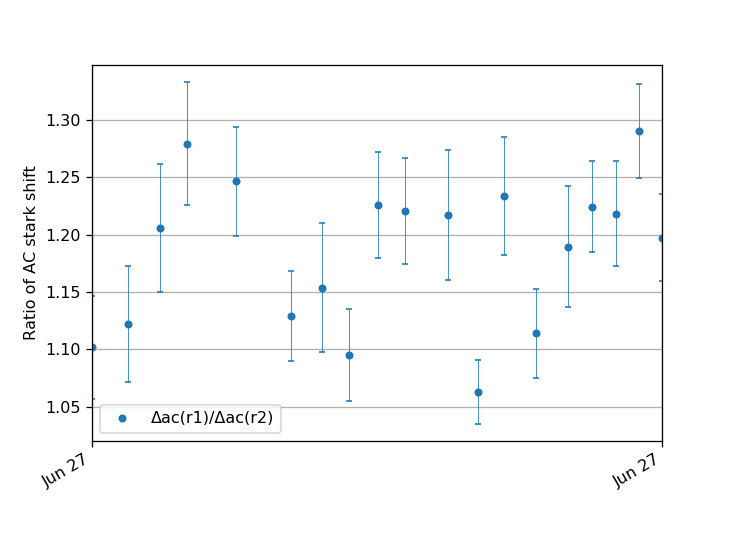

C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


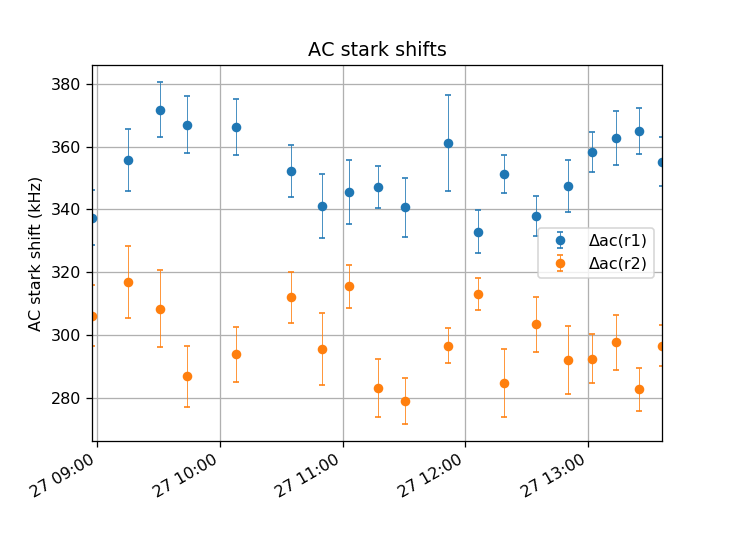

In [6]:
savefig=False
ratio_data=[]
ratio_error=[]
# avetimestamp=[]
timelength=[]
startingtime=[]
startingtime_in_UNIX=[]
# endtime=[]
# endtime_in_UNIX=[]
middletime=[]
# middletime_in_UNIX=[]

ROI1_ac=[]
ROI1_err=[]
ROI2_ac=[]
ROI2_err=[]

for i in range(0,len(assorted['exp_ids'])):
    startingtime.append(dt.datetime.fromtimestamp(assorted['timestamps'][i][0]))
    startingtime_in_UNIX.append(assorted['timestamps'][i][0])
    ratio_data.append(data11[i][2]/data11[i][4])
    error_total=np.sqrt(((1/data11[i][4])*data11[i][3])**2+(((data11[i][2]/(data11[i][4])**2)*data11[i][5])**2))
    ROI1_ac.append(data11[i][2])
    ROI1_err.append(data11[i][3])
    ROI2_ac.append(data11[i][4])
    ROI2_err.append(data11[i][5])
    ratio_error.append(error_total)
    middletime.append(dt.datetime.fromtimestamp(0.5*int(assorted['timestamps'][i][0]+assorted['timestamps'][i][-1])))

# Plotting by clock time
df=pd.DataFrame({ "Δac(r1)/Δac(r2)": ratio_data,'error': ratio_error
                 ,"Δac(r1)": ROI1_ac,'Δac(r2)':ROI2_ac, 'ROI1_err': ROI1_err, 'ROI2_err': ROI2_err
                 ,"middletime":middletime, "startingtime":startingtime
                },index=middletime)
ax=df.plot(y=[ "Δac(r1)/Δac(r2)"],yerr='error',capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None',color=['#1f77b4', '#d62728'])
days=md.DayLocator()
hours=md.HourLocator()
#ax.set_xlim(dt.datetime(2018,5,22))
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('Ratio of AC stark shift')
ax.grid()
#plt.savefig('Alignment_20180415.png')

# AC stark shifts
ax=df.plot(y=["Δac(r1)"],yerr='ROI1_err',capsize=2,alpha=1,lw=0.5,marker='o',markersize=5,linestyle='None')
df.plot(y=["Δac(r2)"],yerr='ROI2_err',capsize=2,alpha=1,lw=0.5,marker='o',markersize=5,linestyle='None',ax=ax)
hours=md.HourLocator()
#ax.xaxis.set_major_locator(days)
#ax.xaxis.set_minor_locator(hours)
ax.xaxis.set_major_locator(hours)
#ax.xaxis.set_major_formatter(md.DateFormatter('%b %d'))
ax.set_ylabel('AC stark shift (kHz)')
ax.grid()
ax.set_title('AC stark shifts')
ax.legend()


<IPython.core.display.Javascript object>


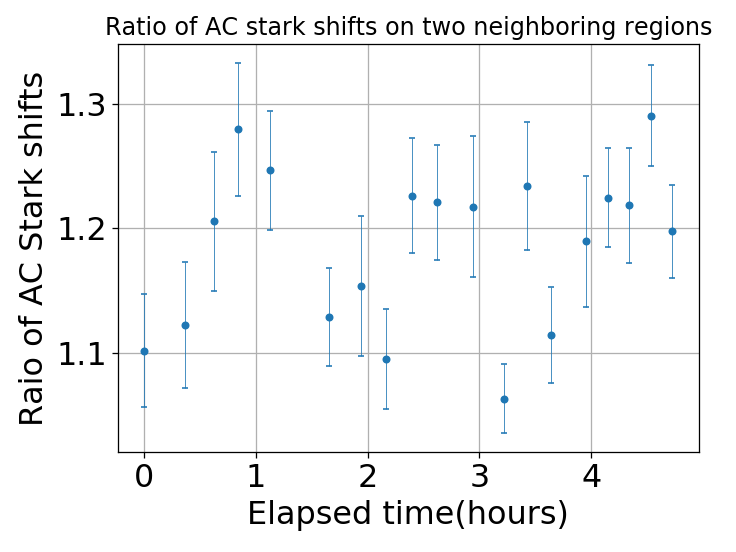

In [7]:
# Plotting by Time difference

timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
#fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
#ax.set_ylim(-0.3,0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='AC Stark shift ratios'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

In [8]:
peakshift=825 # kHz
wx=8.1 # um
spacing = 9.25 # um

def gaussian2(x,amp,x0,sigma,offset):
    res=(amp*sp.exp((-2.0*(x-x0)**2)/(sigma**2)))+offset
    return res

ratio_to_dist=[]  
x=Symbol('x')
dist_max_error=[]
dist_min_error=[]
error_all=[]
for z in range(0,len(ratio_error)):
    print "doing {}-th fit.. out of {}".format(z,len(ratio_error))
    center_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z],x)
    max_val = solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]-ratio_error[z],x)
    min_val =  solve((gaussian2(x,peakshift,spacing/2,wx,0)/gaussian2(x,peakshift,-spacing/2,wx,0))-ratio_data[z]+ratio_error[z],x)
    ratio_to_dist.append(np.float(center_val[0]))
    maxerr = max_val[0] - center_val[0]
    minerr = center_val[0]- min_val[0]
    dist_max_error.append(np.float(maxerr))
    dist_min_error.append(np.float(minerr))
    error_all.append([np.float(maxerr),np.float(minerr)])

doing 0-th fit.. out of 19
doing 1-th fit.. out of 19
doing 2-th fit.. out of 19
doing 3-th fit.. out of 19
doing 4-th fit.. out of 19
doing 5-th fit.. out of 19
doing 6-th fit.. out of 19
doing 7-th fit.. out of 19
doing 8-th fit.. out of 19
doing 9-th fit.. out of 19
doing 10-th fit.. out of 19
doing 11-th fit.. out of 19
doing 12-th fit.. out of 19
doing 13-th fit.. out of 19
doing 14-th fit.. out of 19
doing 15-th fit.. out of 19
doing 16-th fit.. out of 19
doing 17-th fit.. out of 19
doing 18-th fit.. out of 19


<IPython.core.display.Javascript object>


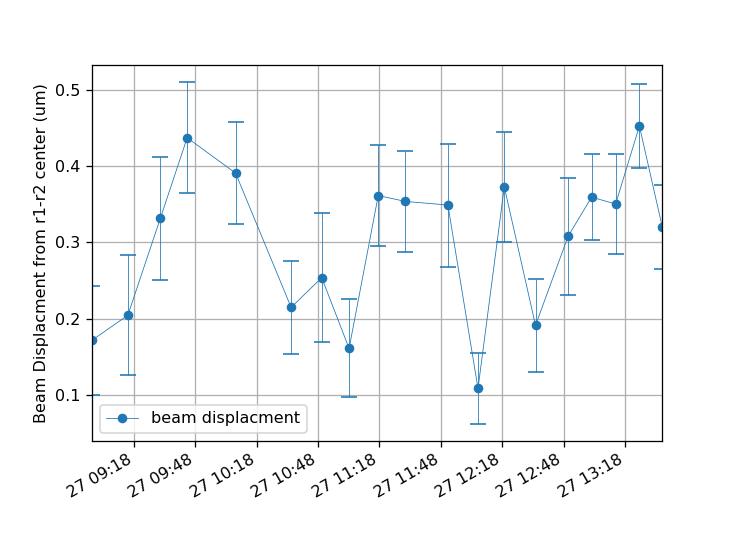

<IPython.core.display.Javascript object>


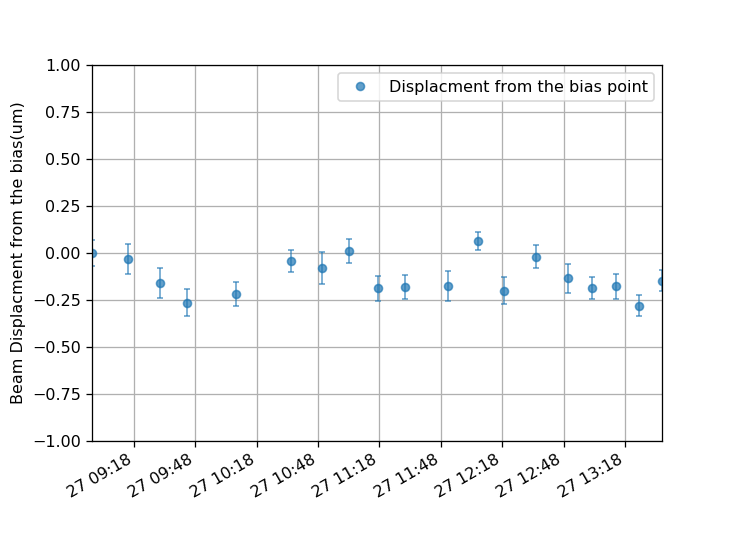

In [9]:
bias_point=np.array(ratio_to_dist[0])
displacement_frombias=ratio_to_dist-bias_point
df_displacement=pd.DataFrame({ "beam displacment": ratio_to_dist,"Displacment from the bias point":-displacement_frombias,'Max_error': dist_max_error,'Min_error': dist_min_error}
                             ,index=middletime)
ax=df_displacement.plot(y=["beam displacment"],yerr=[dist_max_error,dist_min_error],capsize=5,lw=0.5,marker='o',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from r1-r2 center (um)')
#ax.set_xlim(dt.datetime(2018,6,17,12),dt.datetime(2018,6,18,13,0))
ax.grid()
ax=df_displacement.plot(y=["Displacment from the bias point"],yerr=[dist_max_error,dist_min_error],capsize=2,lw=1,marker='o',alpha=0.7,linestyle='None',markersize=5,color=['#1f77b4', '#d62728'])
ax.set_ylabel('Beam Displacment from the bias(um)')
ax.set_ylim(-1,1)
ax.grid()

<IPython.core.display.Javascript object>


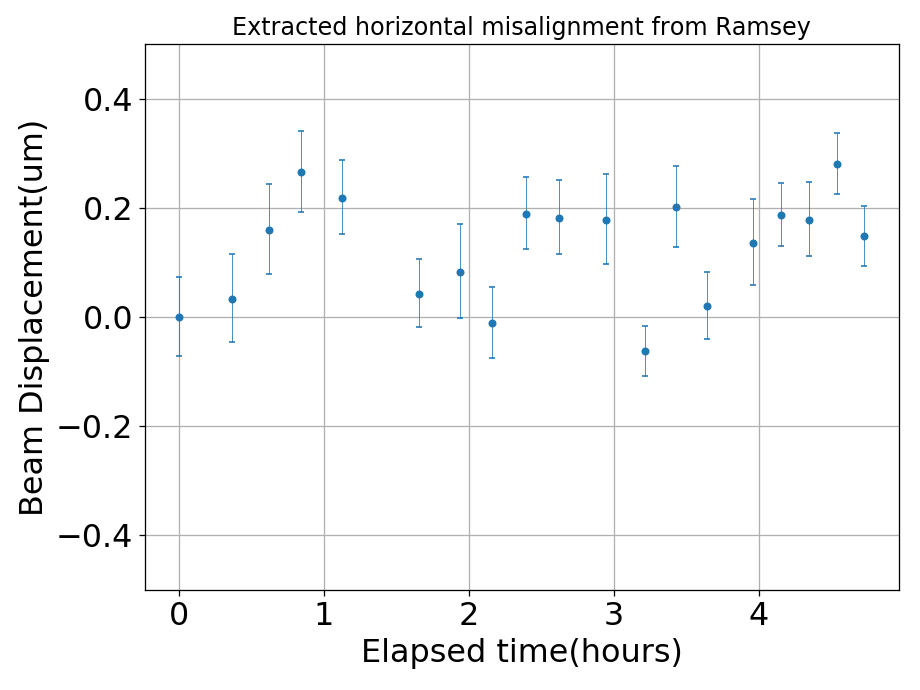

In [10]:
timediff=(startingtime_in_UNIX-startingtime_in_UNIX[0])/(3600)
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,displacement_frombias,yerr=[dist_max_error,dist_min_error],capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Beam Displacement(um)',fontsize=20)
ax.set_title('Extracted horizontal misalignment from Ramsey',fontsize=15)
ax.set_ylim(-0.5,0.5)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Extracted_horizontal_misalignment_from_Ramsey'
# plt.savefig(filename+'.png')
# plt.savefig(filename+'.pdf')
# plt.savefig(filename+'.eps')

# TIME SERIES ANALYSES

In [11]:
keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
         'AAS_redside',
         'AAS_blueside',
 'timestamp_measurements',
 'timestamp_iteration']

actuator_variables=['Red_X','Red_Y']

# exp_ids : This is list for Ramsey experiments.
# There are more experients with AAS on. Add them in this list
AAS_ids=[
        ]

entire_closed_ids=exp_ids+AAS_ids


data={}
for j in range(0,len(entire_closed_ids)):
    exp_id=entire_closed_ids[j]
    q=open_data(exp_id)
    e=0
    for i in q.experiments[e]['iterations']:
        for key in keylist:
            if i==0 and j==0:
                data[key]=[]
            try:
                data[key].append(q.experiments[e]['iterations'][i][key])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)

        for var in actuator_variables:
            if i==0 and j==0:
                data[var]=[]
            try:
                data[var].append(q.experiments[e]['iterations'][i]['variables'][var])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, var)
                

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_27/2018_06_27_08_47_15_Closed-loop Ramsey, Omega Box temperature control/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_27/2018_06_27_09_09_10_Closed-loop Ramsey, Omega Box temperature control/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_27/2018_06_27_09_24_40_Closed-loop Ramsey, Omega Box temperature control/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_27/2018_06_27_09_37_39_Closed-loop Ramsey, Omega Box temperature control/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_27/2018_06_27_09_54_39_Closed-loop Ramsey, Omega Box temperature control/qdp.txt
Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_06_27/2018_06_27_10_26_33_Closed-loop Ramsey, 

<IPython.core.display.Javascript object>


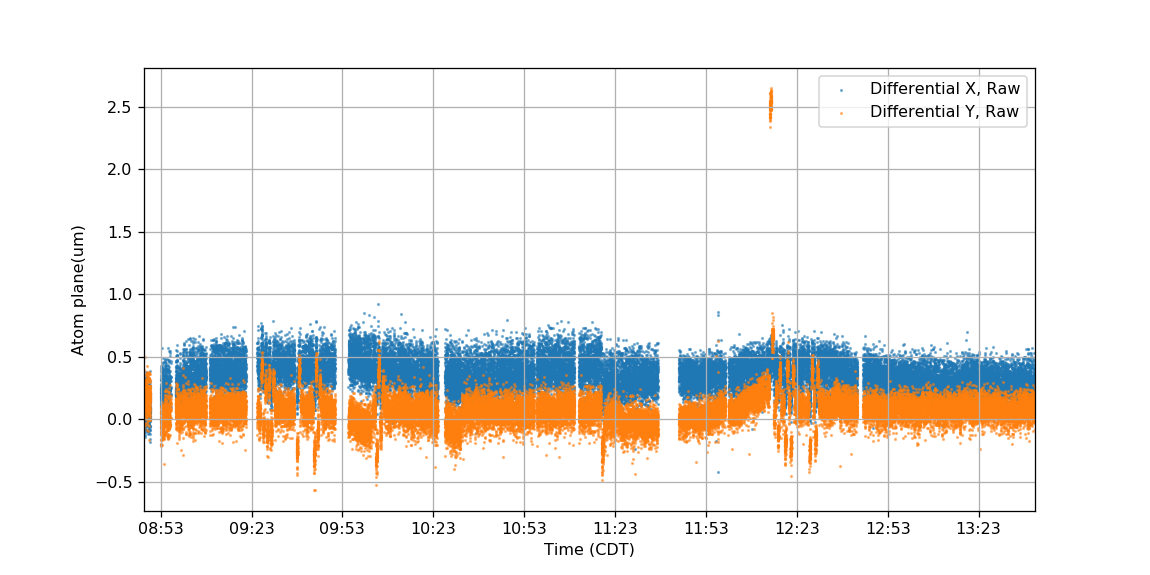

In [12]:
savefig=False
data_cutoff=0
xfmt=md.DateFormatter('%H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))
experiment_start_time=flattendedtimestamps[0]
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

ax.xaxis.set_major_formatter(xfmt)
data_to_plot=flatteneddata0-flatteneddata2-(flatteneddata0[0]-flatteneddata2[0])
ax.scatter(dates,data_to_plot,s=1,alpha=0.5,label='Differential X, Raw')
ax.set_xlim(dates[0],dates[-1])
#ax.set_ylim(-1,1)

data_to_plot2=flatteneddata1-flatteneddata3-(flatteneddata1[0]-flatteneddata3[0])
ax.scatter(dates,data_to_plot2,s=1,alpha=0.5,label='Differential Y, Raw')
ax.grid()
ax.set_xlabel('Time (CDT)')
ax.set_ylabel('Atom plane(um)')
ax.legend()
if savefig:   
    plt.savefig('Alignment_over_night.png')

# Insert room temperature history

<IPython.core.display.Javascript object>


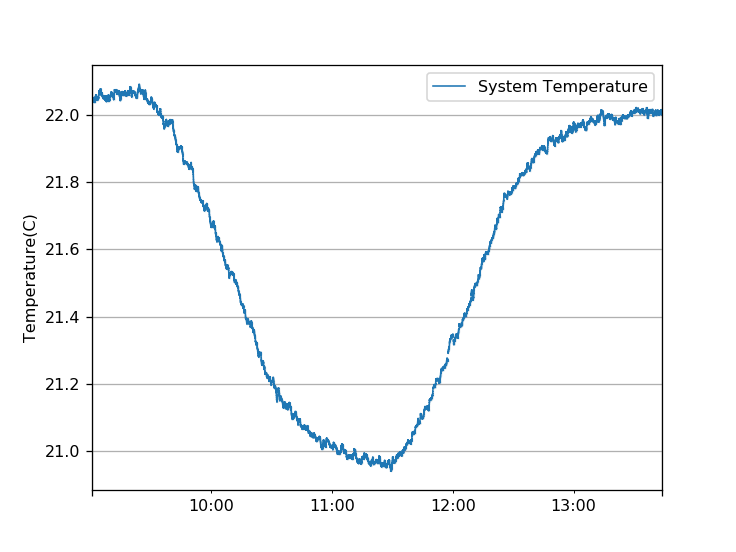

In [13]:
from numpy import genfromtxt
import pandas as pd
my_data=genfromtxt('Rb_labtemperature_20180627_closedloop.csv',delimiter=',')
data_cutoff=53000 # to cutoff bad data at the beginning
temperatures_in_C=np.array(my_data[data_cutoff:,1])
flattendedtimestamps_temp=np.array(my_data[data_cutoff:,0])/2**32
dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps_temp]
samplerate='1S'
df_temperature=pd.DataFrame({'System Temperature': temperatures_in_C,
                },index=dates)

data_to_plot2=df_temperature.resample(samplerate).mean()
ax=data_to_plot2.plot(y=['System Temperature'],alpha=1,lw=1,marker='.',markersize=0.02)
ax.set_ylabel('Temperature(C)')
ax.grid()
ax.legend()

<IPython.core.display.Javascript object>


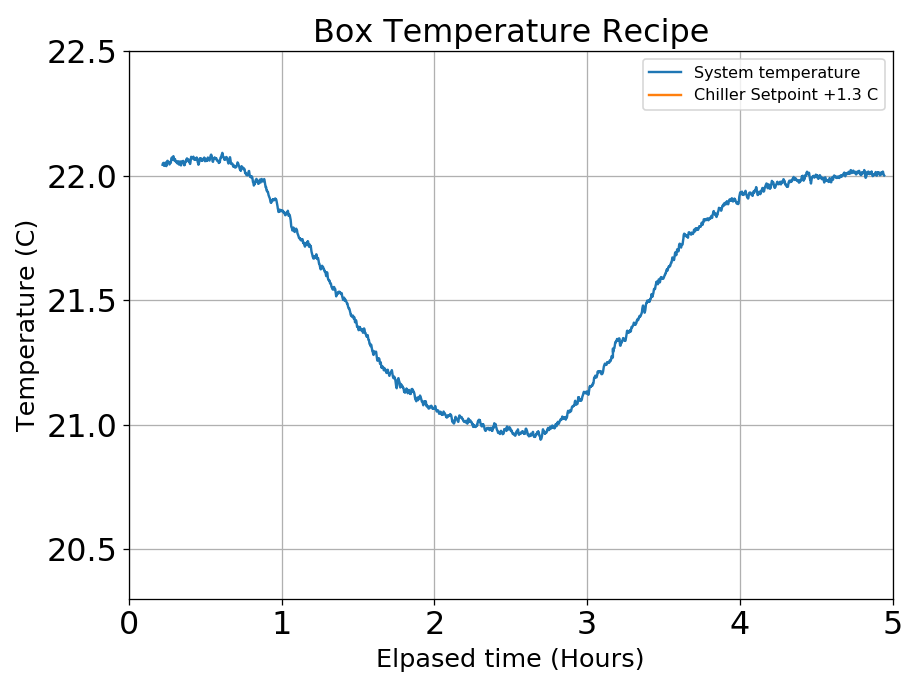

In [14]:
cooking_starttime=dt.datetime(2018,6,22,17,40)
cooking_start_timestamp=time.mktime(cooking_starttime.timetuple())
timetable=np.linspace(cooking_start_timestamp,cooking_start_timestamp+240*60,25)
cookingtable=np.array([21.1, 20.8, 20.4, 20.1, 19.8, 19.5, 19.1, 19.1, 19.1, 19.1, 19.1, 19.1, 19.1, 19.5, 19.8, 20.1, 20.4, 20.8, 21.1,21.1, 21.1, 21.1, 21.1, 21.1, 21.1])


fig, ax=plt.subplots()
fig.set_size_inches(8,6)
offset_chiller=1.3
ax.plot((flattendedtimestamps_temp-experiment_start_time)/3600,temperatures_in_C,label='System temperature')
ax.step((timetable-experiment_start_time)/3600,cookingtable+offset_chiller,where='post',label='Chiller Setpoint +{} C'.format(offset_chiller))
ax.grid()
ax.set_xlabel('Elpased time (Hours)',fontsize=16)
ax.set_ylabel('Temperature (C)',fontsize=16)
ax.set_title('Box Temperature Recipe',fontsize=20)
ax.legend()
ax.set_xlim(0,5)
ax.tick_params(labelsize=20)
plt.tight_layout()
savefig=False
if savefig:
    plt.savefig("20180618_Closedloop_Temperature Recipe.png")

# Pypico

In [15]:
%matplotlib notebook
from numpy import genfromtxt
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time
path_to_pypico='C:/Users/Rb/LabSoftware/pypico/pypico/'

## Full history
my_data=genfromtxt(path_to_pypico+'position_full_history.csv',delimiter=',')
data_cutoff=0 # to cutoff bad data at the beginning
positions=np.array(my_data[data_cutoff:,1:])
timestamps=np.array(my_data[data_cutoff:,0])
dates=[dt.datetime.fromtimestamp(ts) for ts in timestamps]
#samplerate='1S'
df_pypico=pd.DataFrame({'timestamps': timestamps,'channel 0': positions[:,0],'channel 1': positions[:,1],'channel 2': positions[:,2],'channel 3': positions[:,3]
                },index=dates)

#data_to_plot1=df.resample(samplerate).mean()

## Only the final positions
my_data2=genfromtxt(path_to_pypico+'position_final_history.csv',delimiter=',')
data_cutoff=0 # to cutoff bad data at the beginning
positions2=np.array(my_data2[data_cutoff:,1:])
timestamps2=np.array(my_data2[data_cutoff:,0])
dates2=[dt.datetime.fromtimestamp(ts) for ts in timestamps2]
df_pypico2=pd.DataFrame({'timestamps': timestamps2,
    'channel 0': positions2[:,0],
                             'channel 1': positions2[:,1],
                             'channel 2': positions2[:,2],
                             'channel 3': positions2[:,3]
                },index=dates2)


# Camera data analysis

<IPython.core.display.Javascript object>


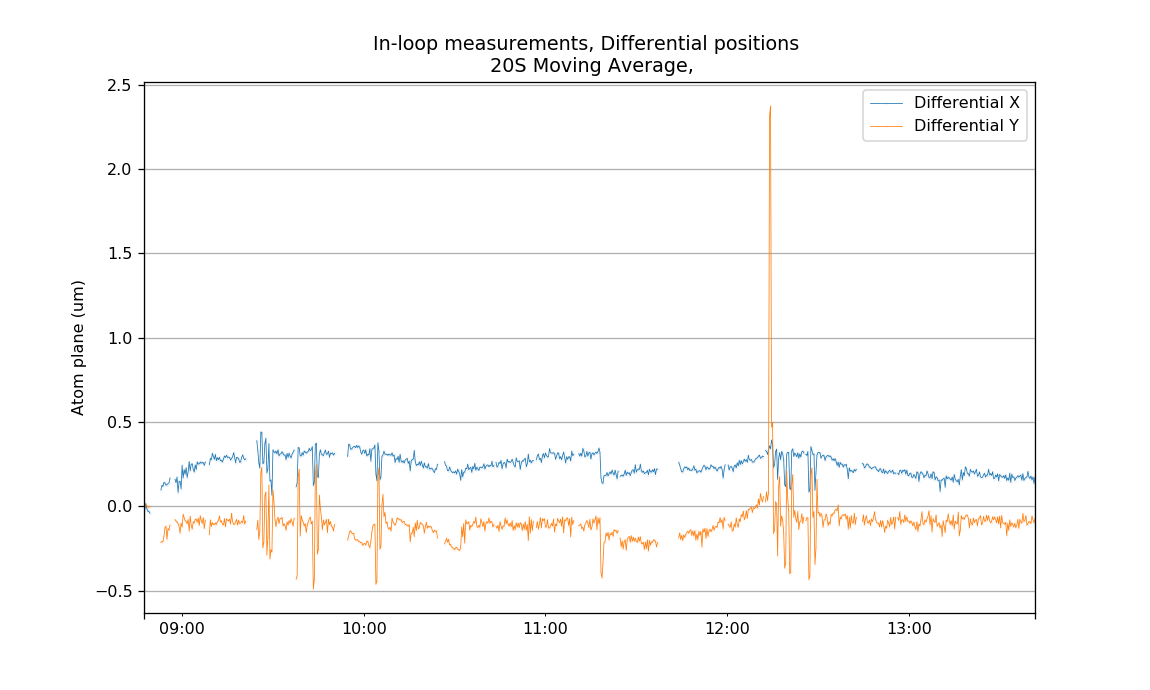

<IPython.core.display.Javascript object>


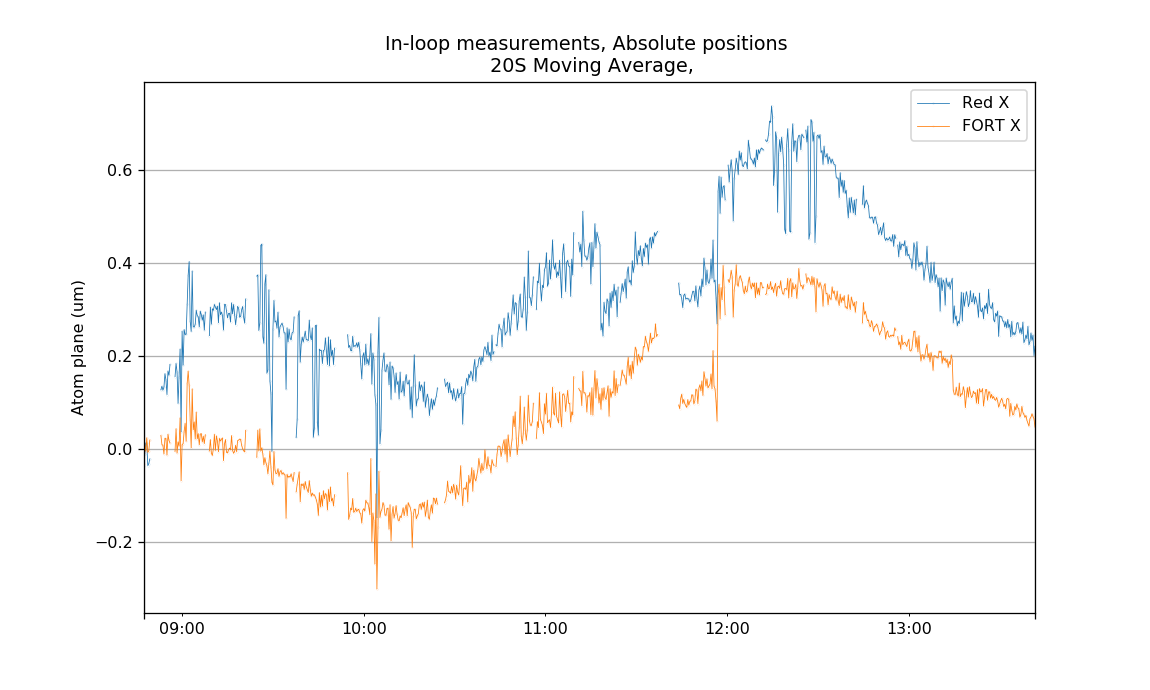

<IPython.core.display.Javascript object>


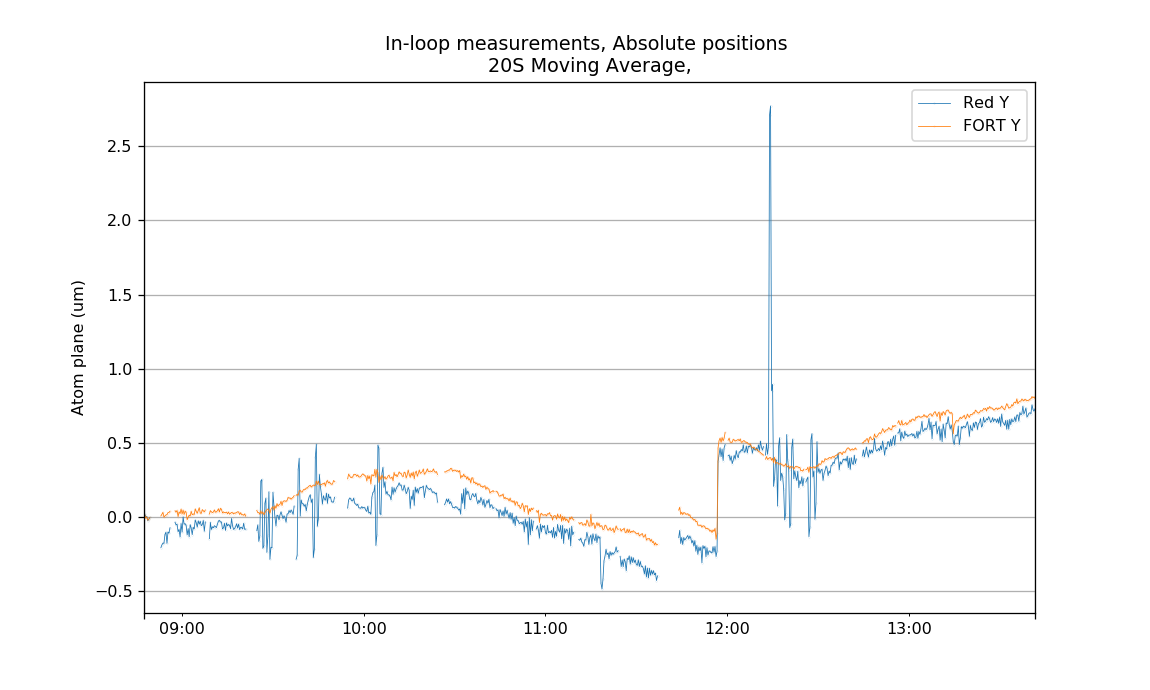

<IPython.core.display.Javascript object>


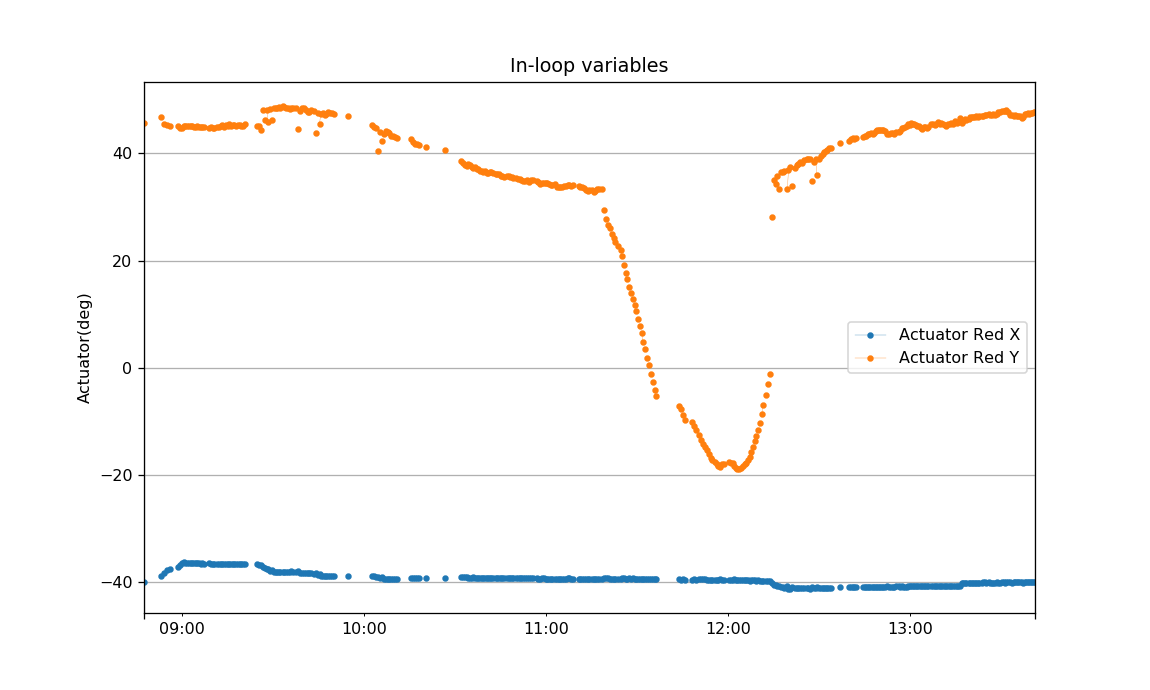

In [16]:
# Using Pandas
import pandas as pd
savefig=False
data_cutoff=0
flattendedtimestamps=np.array(flatten(data['timestamp_measurements']))

dates=[dt.datetime.fromtimestamp(ts) for ts in flattendedtimestamps][data_cutoff:]
dates_iterations=[dt.datetime.fromtimestamp(ts) for ts in data['timestamp_iteration']]

flatteneddata0=np.array(flatten(data[keylist[0]]))[data_cutoff:]
flatteneddata2=np.array(flatten(data[keylist[2]]))[data_cutoff:]
flatteneddata1=np.array(flatten(data[keylist[1]]))[data_cutoff:]
flatteneddata3=np.array(flatten(data[keylist[3]]))[data_cutoff:]

offset_Red_X=np.mean(flatteneddata0[0:100])#np.median(flatteneddata0)
offset_Red_Y=np.mean(flatteneddata1[0:100])#np.median(flatteneddata1)
offset_FORT_X=np.mean(flatteneddata2[0:100])#np.median(flatteneddata2)
offset_FORT_Y=np.mean(flatteneddata3[0:100])#np.median(flatteneddata3)

offsetX0=np.mean((flatteneddata0-flatteneddata2)[0:100])
offsetX_median=np.median(flatteneddata0-flatteneddata2)
offsetY0=np.mean((flatteneddata1-flatteneddata3)[0:100])
offsetY_median=np.median(flatteneddata1-flatteneddata3)
df_camera=pd.DataFrame({'Differential X': flatteneddata0-flatteneddata2-offsetX0,
                 'Differential Y': flatteneddata1-flatteneddata3-offsetY0,
                 'Red X': flatteneddata0-offset_Red_X,
                 'Red Y': flatteneddata1-offset_Red_Y,
                 'FORT X': flatteneddata2-offset_FORT_X,
                 'FORT Y': flatteneddata3-offset_FORT_Y,
                },index=dates)

df_actuators=pd.DataFrame({
                 'Actuator Red X':np.array(data['Red_X']),
                 'Actuator Red Y':np.array(data['Red_Y'])
                },index=dates_iterations)

samplerate='20S'
## 
data_to_plot2=df_camera.resample(samplerate).mean()
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
data_to_plot2.plot(y=['Differential X'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
data_to_plot2.plot(y=['Differential Y'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
ax.set_ylabel('Atom plane (um)')
ax.set_title('In-loop measurements, Differential positions \n {} Moving Average,'.format(samplerate))
ax.grid()
ax.legend()

##
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
data_to_plot2.plot(y=['Red X'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
data_to_plot2.plot(y=['FORT X'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
ax.set_ylabel('Atom plane (um)')
ax.set_title('In-loop measurements, Absolute positions \n {} Moving Average,'.format(samplerate))
ax.grid()
ax.legend()

fig, ax = plt.subplots()
fig.set_size_inches(10,6)
data_to_plot2.plot(y=['Red Y'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
data_to_plot2.plot(y=['FORT Y'],alpha=1,lw=0.5,marker='.',markersize=0.1,ax=ax)
ax.set_ylabel('Atom plane (um)')
ax.set_title('In-loop measurements, Absolute positions \n{} Moving Average,'.format(samplerate))
ax.grid()
ax.legend()

data_to_plot3=df_actuators.resample(samplerate).mean()

fig, ax = plt.subplots()
fig.set_size_inches(10,6)
data_to_plot3.plot(y=['Actuator Red X'],alpha=1,lw=0.2,marker='.',ax=ax)
data_to_plot3.plot(y=['Actuator Red Y'],alpha=1,lw=0.2,marker='.',ax=ax)
ax.set_title('In-loop variables'.format(samplerate))
ax.set_ylabel('Actuator(deg)')
ax.grid()
ax.legend()


<IPython.core.display.Javascript object>


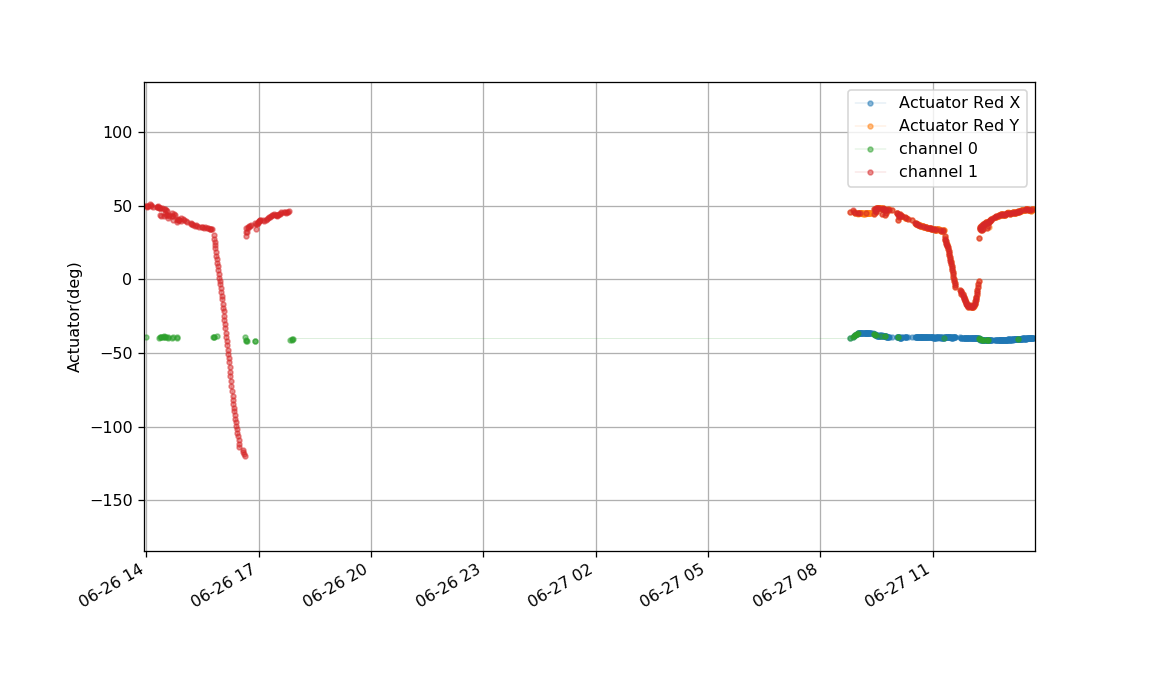

In [30]:
# Overlaying Pypico and CsPy variables
frames=[df_temperature,df,df_displacement,df_camera,df_actuators,df_pypico2]
result=pd.concat(frames)
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
result.plot(y=['Actuator Red X','Actuator Red Y','channel 0','channel 1'],alpha=0.5,lw=0.2,marker='.',ax=ax)
#result.plot(y=['Actuator Red Y'],alpha=1,lw=0.2,marker='.',ax=ax)
#ax.set_title('In-loop variables'.format(samplerate))
ax.set_ylabel('Actuator(deg)')
ax.grid()
ax.set_xlim(dt.datetime(2018,6,26,13,56),)
ax.legend()

<IPython.core.display.Javascript object>


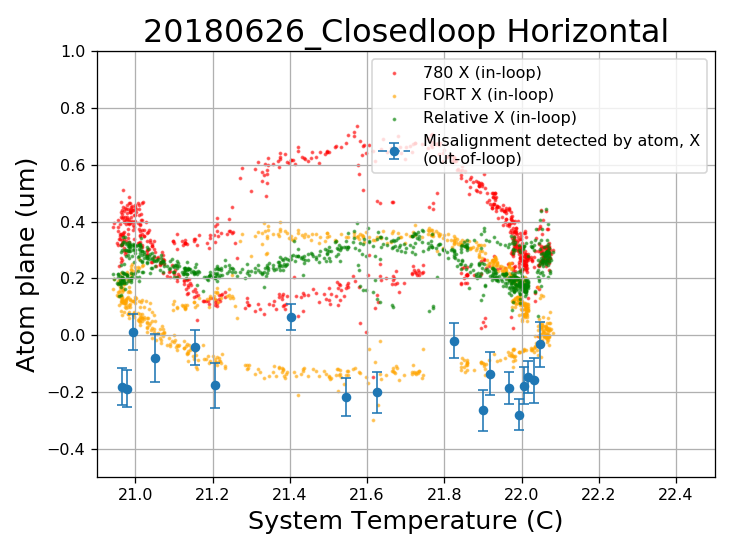

C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\core\numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


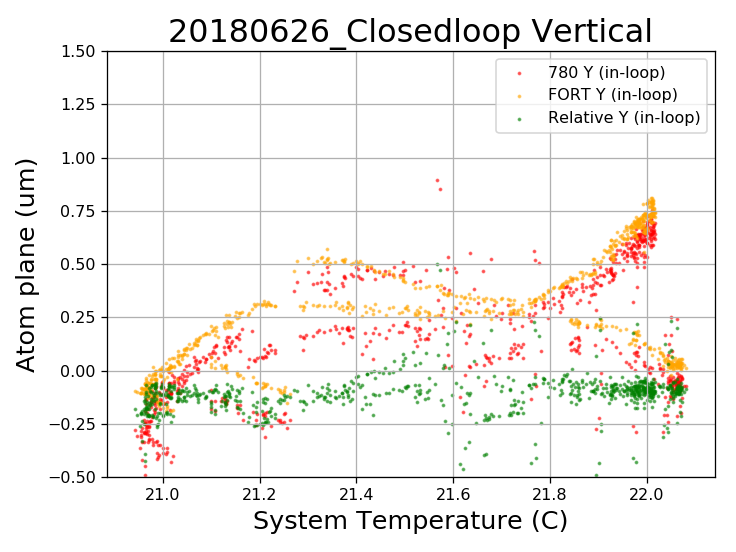

In [37]:
filename='20180626_Closedloop'
savefig=False
frames=[df_temperature,df,df_displacement,df_camera,df_actuators,df_pypico2]
result=pd.concat(frames)
samplerate='20S'
data_to_plot3=result.resample(samplerate).mean()
fig, ax = plt.subplots()
data_to_plot3.plot(kind='scatter',y='Red X',x='System Temperature',alpha=0.5,s=2,color='r',label='780 X (in-loop)',ax=ax)
data_to_plot3.plot(kind='scatter',y='FORT X',x='System Temperature',alpha=0.5,s=2,color='orange',ax=ax,label='FORT X (in-loop)')
data_to_plot3.plot(kind='scatter',y='Differential X',x='System Temperature',alpha=0.5,s=2,color='green',ax=ax,label='Relative X (in-loop)')
#data_to_plot3.dropna().plot(y="Displacment from the bias point",yerr='Max_error',x='System Temperature',capsize=3,lw=1,marker='o',alpha=1,linestyle='--',markersize=5,ax=ax,label='Misalignment detected by atom, X\n(out-of-loop)')
data_to_plot3.plot(y="Displacment from the bias point",yerr='Max_error',x='System Temperature',capsize=3,lw=1,marker='o',alpha=1,linestyle='--',markersize=5,ax=ax,label='Misalignment detected by atom, X\n(out-of-loop)')
#data_to_plot3.plot(y="Displacment from the bias point",x='System Temperature',capsize=2,lw=1,marker='o',alpha=0.7,linestyle='None',markersize=5,color=['#1f77b4', '#d62728'],ax=ax)
ax.set_ylabel('Atom plane (um)',fontsize=16)
ax.set_xlabel('System Temperature (C)',fontsize=16)
ax.grid()
ax.legend()
ax.set_xlim(20.9,22.5)
ax.set_ylim(-0.5,1)
ax.set_title(filename+' Horizontal',fontsize=20)
plt.tight_layout()
if savefig:
    plt.savefig(filename+"_Xcurve.png")

fig, ax2 = plt.subplots()
data_to_plot3.plot(kind='scatter',y='Red Y',x='System Temperature',alpha=0.5,s=2,color='r',label='780 Y (in-loop)',ax=ax2)
data_to_plot3.plot(kind='scatter',y='FORT Y',x='System Temperature',alpha=0.5,s=2, color='orange',ax=ax2,label='FORT Y (in-loop)')
data_to_plot3.plot(kind='scatter',y='Differential Y',x='System Temperature',alpha=0.5,s=2, color='green',ax=ax2,label='Relative Y (in-loop)')
ax2.set_ylabel('Atom plane (um)',fontsize=16)
ax2.set_xlabel('System Temperature (C)',fontsize=16)
ax2.grid()
ax2.legend()
ax.set_xlim(20.9,22.5)
ax2.set_ylim(-0.5,1.5)
ax2.set_title(filename+' Vertical',fontsize=20)
plt.tight_layout()
if savefig:
    plt.savefig(filename+"_Ycurve.png")

<IPython.core.display.Javascript object>


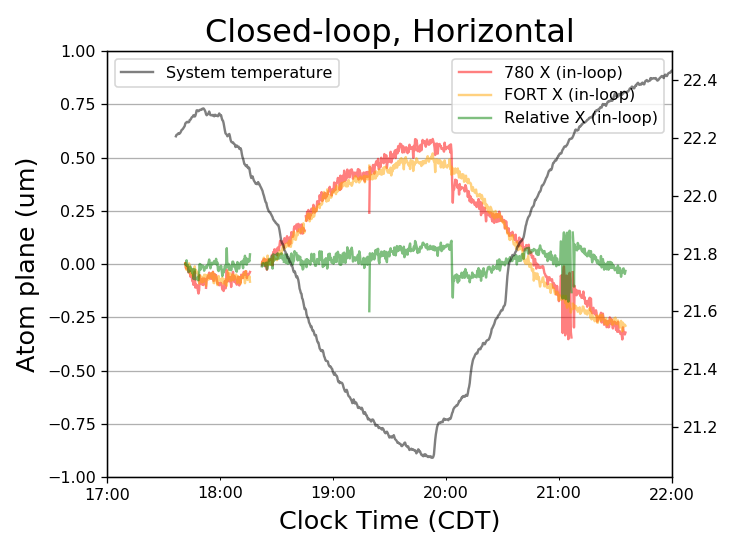

<IPython.core.display.Javascript object>


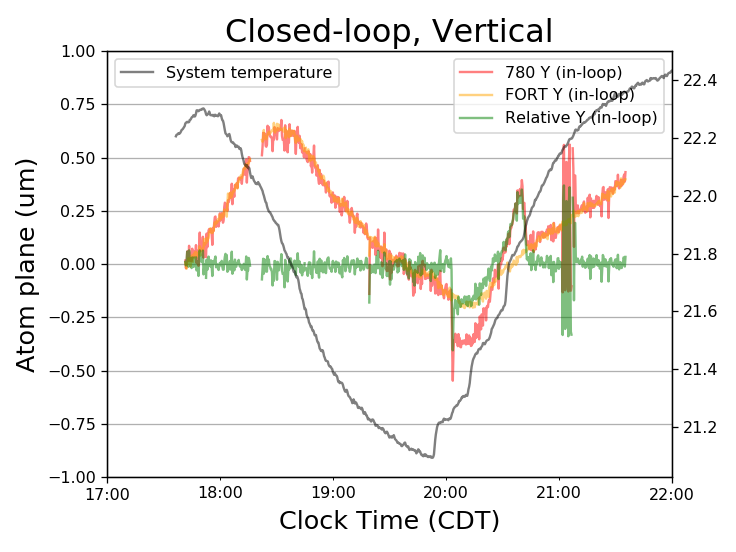

In [160]:
fig, ax = plt.subplots()
data_to_plot3.plot(y='Red X',alpha=0.5,color='r',label='780 X (in-loop)',ax=ax)
data_to_plot3.plot(y='FORT X',alpha=0.5,color='orange',ax=ax,label='FORT X (in-loop)')
data_to_plot3.plot(y='Differential X',alpha=0.5,color='green',ax=ax,label='Relative X (in-loop)')
ax.set_ylabel('Atom plane (um)',fontsize=16)
ax.set_xlabel('Clock Time (CDT)',fontsize=16)
ax2=ax.twinx()
data_to_plot3.plot(y='System Temperature',alpha=0.5,color='black',label='System temperature',ax=ax2)
#'System Temperature'
ax.grid()
ax.legend()
ax.set_xlim(dt.datetime(2018,6,22,17,0),dt.datetime(2018,6,22,22,0))
ax.set_ylim(-1,1)
ax.set_title('Closed-loop, Horizontal',fontsize=20)
plt.tight_layout()

fig, ax = plt.subplots()
data_to_plot3.plot(y='Red Y',alpha=0.5,color='r',label='780 Y (in-loop)',ax=ax)
data_to_plot3.plot(y='FORT Y',alpha=0.5,color='orange',ax=ax,label='FORT Y (in-loop)')
data_to_plot3.plot(y='Differential Y',alpha=0.5,color='green',ax=ax,label='Relative Y (in-loop)')
ax.set_ylabel('Atom plane (um)',fontsize=16)
ax.set_xlabel('Clock Time (CDT)',fontsize=16)
ax2=ax.twinx()
data_to_plot3.plot(y='System Temperature',alpha=0.5,color='black',label='System temperature',ax=ax2)

ax.grid()
ax.legend()
ax.set_xlim(dt.datetime(2018,6,22,17,0),dt.datetime(2018,6,22,22,0))
ax.set_ylim(-1,1)
ax.set_title('Closed-loop, Vertical',fontsize=20)
plt.tight_layout()

<IPython.core.display.Javascript object>


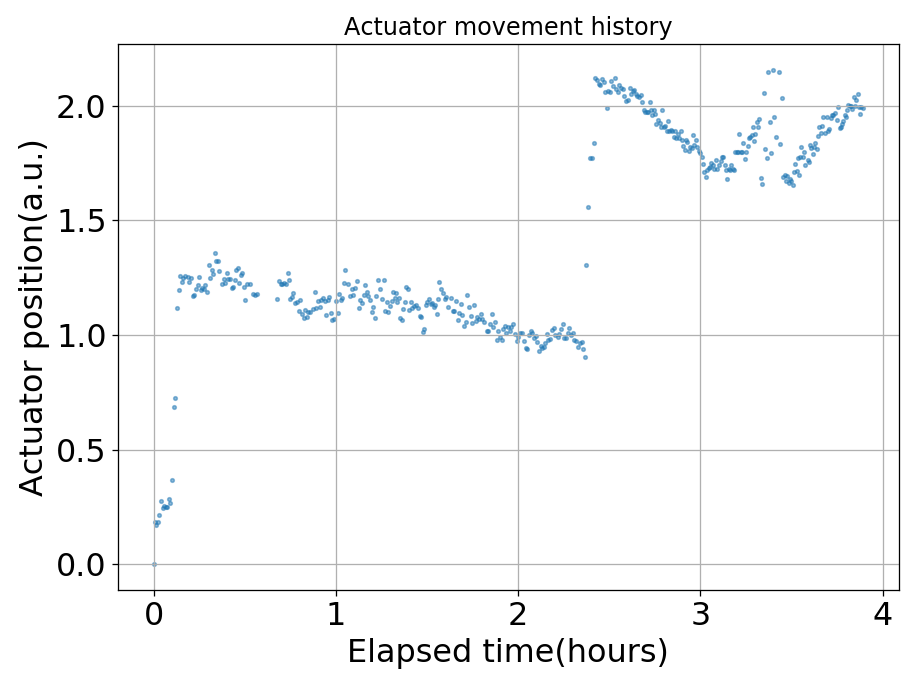

<IPython.core.display.Javascript object>


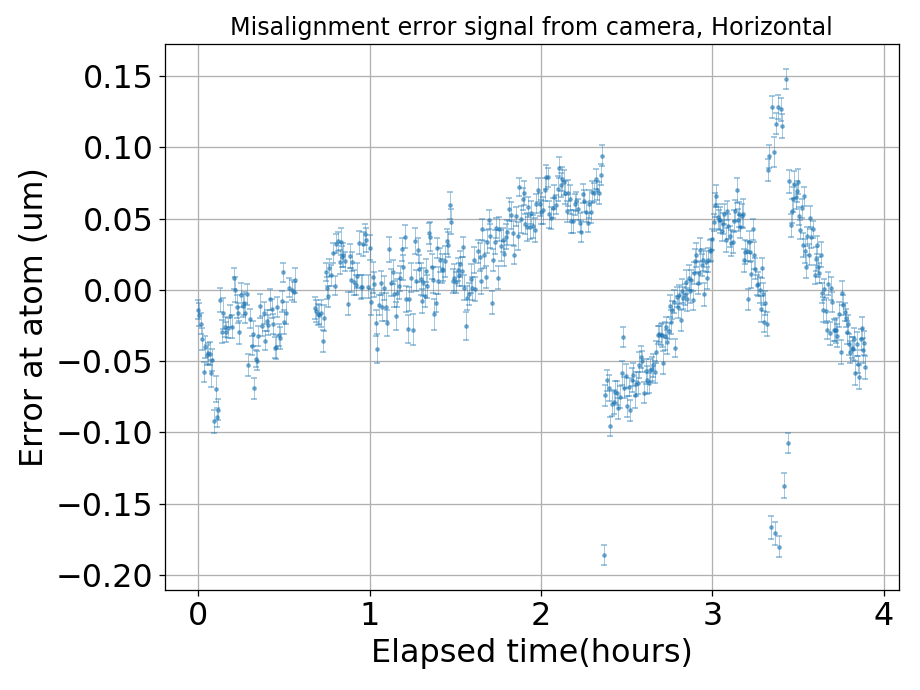

In [161]:
## Actuator Plot
savefig=False
actuator_x=np.array(data['Red_X'])
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(elapsed_time_in_hours,actuator_x-actuator_x[0],alpha=0.5,s=5)
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Actuator position(a.u.)',fontsize=20)
ax.set_title('Actuator movement history',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Actuator X History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

############ Camera error signal, X
camera_error_x=[]
camera_error_sigma_x=[]

samples=100
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        camera_error_x.append(data[keylist[4]][i]['error_x']/calibration_factor)
        camera_error_sigma_x.append(data[keylist[4]][i]['sigma_x']/math.sqrt(samples))
    except:
        print i
        camera_error_x.append(np.nan)
        camera_error_sigma_x.append(np.nan)
        
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(elapsed_time_in_hours,camera_error_x,yerr=camera_error_sigma_x,capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=2,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Error at atom (um)',fontsize=20)
ax.set_title('Misalignment error signal from camera, Horizontal',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Camera AAS X History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

<IPython.core.display.Javascript object>


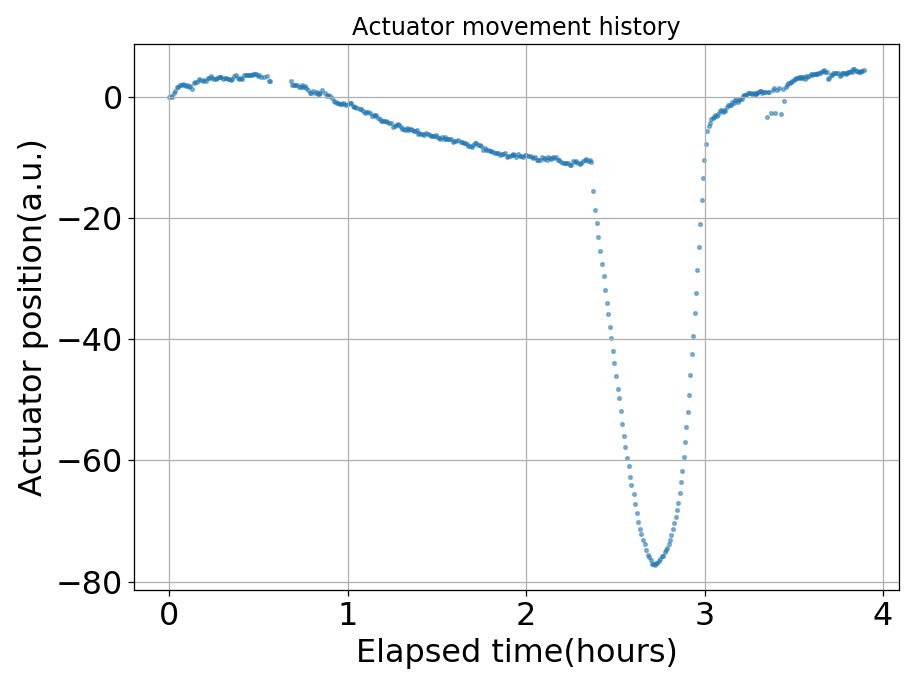

<IPython.core.display.Javascript object>


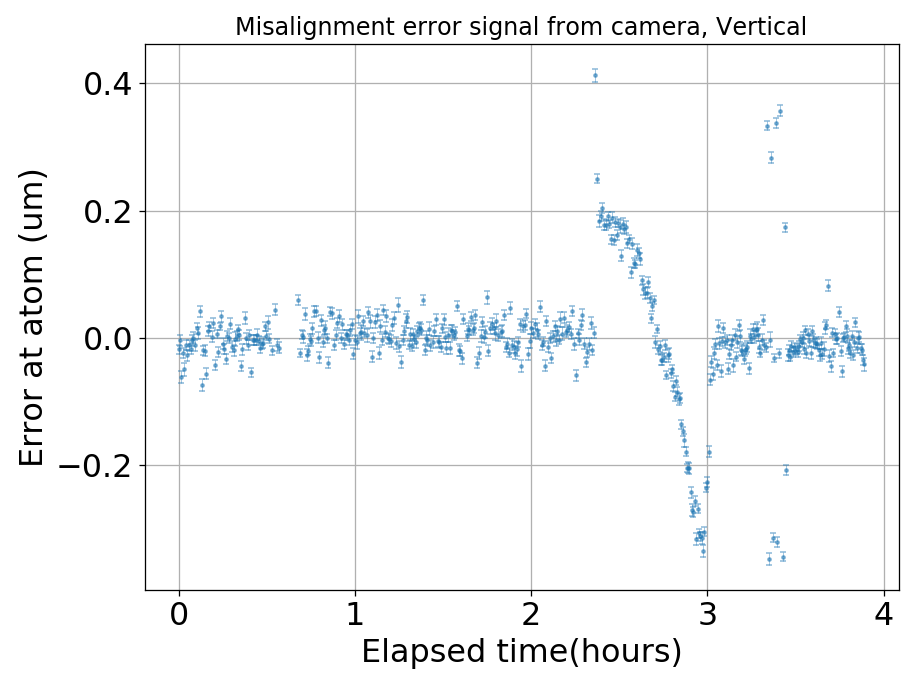

In [162]:
## Actuator Plot
savefig=False
actuator_y=np.array(data['Red_Y'])
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
plt.scatter(elapsed_time_in_hours,actuator_y-actuator_y[0],alpha=0.5,s=5)
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Actuator position(a.u.)',fontsize=20)
ax.set_title('Actuator movement history',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Actuator Y History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

############ Camera error signal, Y
camera_error_y=[]
camera_error_sigma_y=[]

samples=100
calibration_factor=12.0
elapsed_time_in_hours=np.array(data['timestamp_iteration'])/3600.0-np.array(data['timestamp_iteration'][0])/3600.0
for i in range(0,len(data[keylist[4]])):
    try:
        camera_error_y.append(data[keylist[4]][i]['error_y']/calibration_factor)
        camera_error_sigma_y.append(data[keylist[4]][i]['sigma_y']/math.sqrt(samples))
    except:
        print i
        camera_error_y.append(np.nan)
        camera_error_sigma_y.append(np.nan)
        
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(elapsed_time_in_hours,camera_error_y,yerr=camera_error_sigma_y,capsize=2,alpha=0.5,lw=0.5,marker='o',markersize=2,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Error at atom (um)',fontsize=20)
ax.set_title('Misalignment error signal from camera, Vertical',fontsize=15)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()
filename='Camera AAS Y History'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')

# Figuring out the dead region

<IPython.core.display.Javascript object>


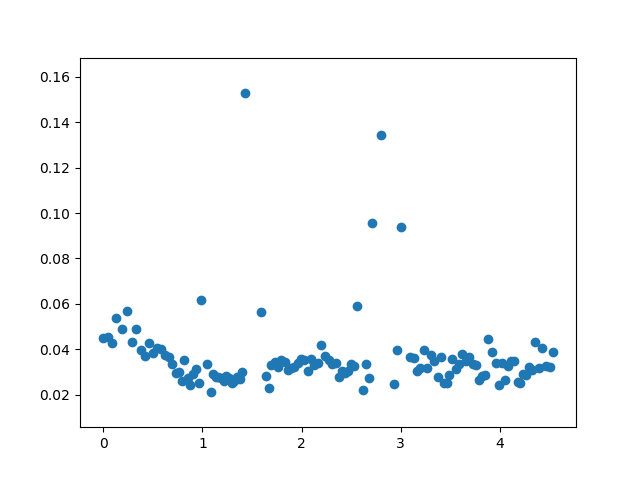

In [21]:
fig, ax= plt.subplots()
sorted_times=np.sort(elapsed_time_in_hours)
dead_times=sorted_times[1:]-sorted_times[0:-1]
ax.scatter(sorted_times[0:-1],dead_times)
threshold=2
dead_T=[]
dead_duration=[]
for i in range(0,len(dead_times)):
    if dead_times[i]>threshold:
        print 'T={}, duration of :{}'.format(sorted_times[0:-1][i],dead_times[i])
        dead_T.append(sorted_times[0:-1][i])
        dead_duration.append(dead_times[i])

<IPython.core.display.Javascript object>


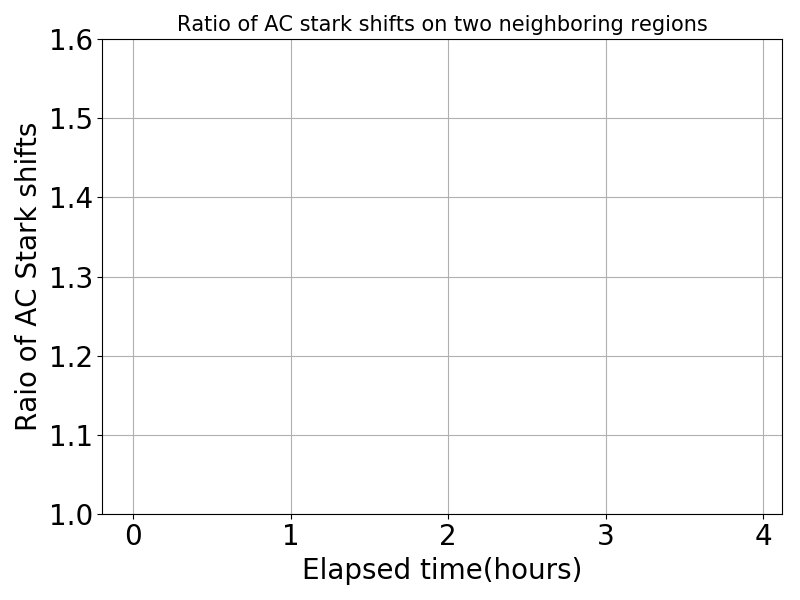

In [23]:
correction=0.7
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.errorbar(timediff,ratio_data,yerr=ratio_error,capsize=2,alpha=1,lw=0.5,marker='o',markersize=4,linestyle='None')
ax.set_xlabel('Elapsed time(hours)',fontsize=20)
ax.set_ylabel('Raio of AC Stark shifts',fontsize=20)
ax.set_title('Ratio of AC stark shifts on two neighboring regions',fontsize=15)
# for i in range(0,len(dead_T)):
#     ax.fill_between([dead_T[i]+correction,dead_T[i]+dead_duration[i]-correction],1.1-0.3,1.1+0.3,alpha=0.1,color='r')
ax.set_ylim(1.3-0.3,1.3+0.3)
ax.tick_params(labelsize=20)
ax.grid()
plt.tight_layout()

# Allan deviation

In [51]:
from IPython.display import display, clear_output
name='20180615_openloop_boxtesting'
# Allan 
tau_list=range(1,100)+range(101,1001,10)+range(1002,10002,10)+range(10003,100003,10)#+range(80004,100004,50)+range(100005,1000005,500)
samplerates=[]
for i in tau_list:
    samplerates.append('{}S'.format(i))
        
samplerate='1S'

var_list={}

original_resampled=df.resample(samplerate).mean()

for i in range(0,len(tau_list)):
    avg_samplerate=samplerates[i]
    tau=tau_list[i]
    clear_output()
    display('Tau: '+str(tau))
    try:
        downsampled=df.resample(avg_samplerate).mean() # Takes block-average for given time chuck size
        for key in downsampled:
            values=downsampled[key].values
            Xtau=values[1:]
            Xo=values[0:-1]
            var=np.nanmean(np.abs(Xtau-Xo))
            if i==0:
                var_list[key]=[]
            var_list[key].append(var)
    except:
        pass
    
try:
    np.save(name+'_taulist',tau_list)
    np.save(name+'_X',np.sqrt(0.5*np.array(var_list['Differential X'])))
    np.save(name+'_Y',np.sqrt(0.5*np.array(var_list['Differential Y'])))
except:
    pass

'Tau: 99993'

<IPython.core.display.Javascript object>


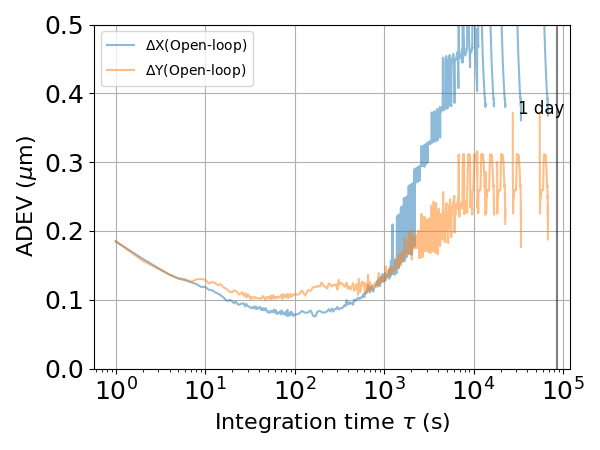

In [52]:
tau_list=np.load(name+'_taulist.npy')
Xlist=np.load(name+'_X.npy')
Ylist=np.load(name+'_Y.npy')

# tau_list2=np.load('20180525_closedloop_taulist.npy')
# Xlist2=np.load('20180525_closedloop_X.npy')
# Ylist2=np.load('20180525_closedloop_Y.npy')


savefig=False
fig, ax = plt.subplots()
fig.set_size_inches(6,4.5)
ax.semilogx(tau_list, Xlist,label=r'$\Delta$X(Open-loop)',alpha=0.5)
ax.semilogx(tau_list, Ylist,label=r'$\Delta$Y(Open-loop)',alpha=0.5)
# ax.semilogx(tau_list2, Xlist2,label=r'$\Delta$X(Closed-loop)',alpha=0.5)
# ax.semilogx(tau_list2, Ylist2,label=r'$\Delta$Y(Closed-loop)',alpha=0.5)
ax.tick_params(labelsize=18)
ax.legend()
plt.axvline(x=86400,color='black',alpha=0.5)
#ax.set_xlim(1,)
#ax.set_title('Allan Deviation (Open-loop vs Closed-loop)',size=)
ax.set_xlabel(r'Integration time $\tau$ (s)',size=16)
ax.set_ylabel(r'ADEV ($\mu$m)',size=16)
#ax.text(10**0,0.3,'Feedback uses last 100 measurements(~ 30 sec)\n from each iteration.\nFeedback cycle time typically ~ 2 min, when activated')
ax.text(10**4.5,0.37,'1 day',size=12)
#ax.axvline(x=60,color='k',alpha=0.3)
ax.set_ylim(0.0,0.5)
ax.grid()
plt.tight_layout()
filename='20180522_AllanDeviation_comparison'
if savefig:
    plt.savefig(filename+'.png')
    plt.savefig(filename+'.pdf')
    plt.savefig(filename+'.eps')
